# Pyro models

Load data and libraries

In [1]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.stats import poisson
import torch
import seaborn as sns

data = pd.read_csv(here("data/recent_donations.csv"))
data

# remove columns y_2020 to y_2023
# data = data.drop(columns=["y_2020", "y_2021", "y_2022", "y_2023"])

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


Clean the dataframe and divide it into the time series and the covariates of our model

In [2]:
# ------------------------------------------------------------------
# Required libraries
# ------------------------------------------------------------------
import polars as pl
import numpy as np
import torch

# ------------------------------------------------------------------
# 1. Load data into a Polars DataFrame
# ------------------------------------------------------------------
# df = pl.read_csv("file.csv")          # Uncomment if reading from file
df = pl.from_pandas(data)               # Convert from pandas if already in memory

# ------------------------------------------------------------------
# 2. Collect year columns and build the observation matrix [N, T]
# ------------------------------------------------------------------
year_cols = sorted([c for c in df.columns if c.startswith("y_")])
T = len(year_cols)

obs = (
    df.select(year_cols)                # Select y_* columns
      .fill_null(0)                     # Replace NaNs by 0
      .to_numpy()
      .astype(int)                      # Ensure integer type
)

# ------------------------------------------------------------------
# 3. Create fixed covariates per individual
# ------------------------------------------------------------------
df = df.with_columns(
    [
        (pl.col("gender") == "F").cast(pl.Int8).alias("gender_code"),      # 0 = M, 1 = F
        (
            (pl.col("birth_year") - pl.col("birth_year").mean()) /
            pl.col("birth_year").std()
        ).alias("birth_year_norm")                                         # Standardised birth year
    ]
)

birth_year_norm = df["birth_year_norm"].to_numpy()    # Shape [N]
gender_code     = df["gender_code"].to_numpy()        # Shape [N]

# ------------------------------------------------------------------
# 4. Build dynamic covariates (age and COVID dummy)
# ------------------------------------------------------------------
years_num = np.array([int(c[2:]) for c in year_cols])                 # e.g. [2009, …, 2023]
ages      = years_num[None, :] - df["birth_year"].to_numpy()[:, None] # Shape [N, T]
ages_norm = (ages - ages.mean()) / ages.std()                         # Standardised age

covid_years = np.isin(years_num, [2020, 2021, 2022]).astype(float)    # Shape [T]
covid_years = np.tile(covid_years, (df.height, 1))                    # Shape [N, T]

# ------------------------------------------------------------------
# 5. Assemble the full covariate tensor [N, T, 5]
#    Order: birth_year_norm, gender_code, ages_norm, covid_years, const
# ------------------------------------------------------------------
base_cov  = np.stack([birth_year_norm, gender_code], axis=1)          # Shape [N, 2]
base_cov  = np.repeat(base_cov[:, None, :], T, axis=1)                # [N, T, 2]

dyn_cov   = np.stack([ages_norm, covid_years], axis=2)                # [N, T, 2]

const_cov = np.ones((df.height, T, 1), dtype=np.float32)              # Constant term

full_cov  = np.concatenate([base_cov, dyn_cov, const_cov], axis=2)    # [N, T, 5]
cov_names = ["birth_year_norm",
             "gender_code",
             "ages_norm",
             "covid_years",
             "const"]

# Conversione a torch tensor (opzionale)
full_covariates_torch = torch.tensor(full_covariates, dtype=torch.float)


obs

array([[0, 0, 0, ..., 1, 3, 1],
       [2, 1, 2, ..., 3, 3, 4],
       [4, 2, 3, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 2, 3],
       [0, 0, 0, ..., 0, 2, 1]])

In [3]:
# X = np.concatenate([obs[i, :].reshape(-1, 1) for i in range(obs.shape[0])])
# lengths = [obs.shape[1]] * obs.shape[0]  # lunghezze delle sequenze

## SPERIMENTAZIONE:

In [4]:
from hmmlearn import hmm, vhmm

categorical = vhmm.CategoricalHMM(
    n_components=2,  # Number of hidden states
    n_iter=1000,
    tol=1e-4,
    init_params='ste',
    params='ste',
    random_state=42
)

categorical.fit(X, lengths)

AttributeError: module 'hmmlearn.vhmm' has no attribute 'CategoricalHMM'

## HMM without covariates

Let’s start with our models!
First of all, we will start with a Hidden Markov Model. We don’t use a classic HMM with a Gaussian as emission probabilities but a categorical (discrete) emission distribution, where each hidden state emits observable symbols according to its own categorical probability vector.

For inference, we use Stochastic Variational Inference (SVI), which allows us to approximate the posterior distributions of the model parameters efficiently. The optimization is performed using the Adam optimizer, an adaptive learning rate method that helps the model converge quickly and stably during training.

In [5]:
from pyro.infer import SVI, TraceEnum_ELBO  

num_states = 3  # Number of hidden states
num_obs = int(obs_torch.max().item()) + 1

pyro.clear_param_store()  # resetta tutti i parametri!


def model(observations):
    N, T = observations.shape
    num_states = 3

    emission_probs = pyro.param("emission_probs", torch.ones(num_states, num_obs) / num_obs, constraint=dist.constraints.simplex)
    trans_probs = pyro.param("trans_probs", torch.ones(num_states, num_states) / num_states, constraint=dist.constraints.simplex)
    init_probs = pyro.param("init_probs", torch.ones(num_states) / num_states, constraint=dist.constraints.simplex)

    with pyro.plate("individuals", N):
        state = pyro.sample("state_0", dist.Categorical(init_probs))
        for t in range(T):
            pyro.sample(
                f"obs_{t}",
                dist.Categorical(probs=emission_probs[state]),
                obs=observations[:, t]
            )
            if t < T - 1:
                state = pyro.sample(
                    f"state_{t+1}",
                    dist.Categorical(trans_probs[state])
                )
# fake_obs = torch.zeros(5, 10)  # 5 individui, 10 osservazioni temporali
# pyro.render_model(model, model_args=(fake_obs,))

C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Loss at step 0: 400431.4375


C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state

Loss at step 20: 324836.59375
Loss at step 40: 308201.3125
Loss at step 60: 300125.6875
Loss at step 80: 293831.375
Loss at step 100: 284797.09375


C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state

Loss at step 120: 284374.90625


C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate site

Loss at step 140: 288510.96875


C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Loss at step 160: 280958.875


C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Loss at step 180: 276805.875


C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'state_0', 'state_9', 'state_12', 'state_5', 'state_10', 'state_8', 'state_11', 'state_7', 'state_13', 'state_2', 'state_3', 'state_4', 'state_6', 'state_14', 'state_1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


Emission probabilities:
 [[0.5666607  0.19347118 0.14834104 0.07155315 0.01550294 0.00447095]
 [0.5682594  0.1939444  0.14714856 0.07131724 0.01577074 0.00355964]
 [0.58102167 0.18673871 0.14169626 0.07110254 0.015733   0.00370782]]
Transition probabilities:
 [[0.49828446 0.26471248 0.23700307]
 [0.10383585 0.16157764 0.73458654]
 [0.14641745 0.8048122  0.04877038]]
Initial probabilities:
 [0.16284195 0.19725384 0.6399042 ]


In [13]:
def guide(observations): pass

In [15]:
from tqdm.notebook import tqdm
from pyro.optim import ClippedAdam

pyro.clear_param_store()  # resetta tutti i parametri!

STEPS = 200 # optimization steps
optimizer = ClippedAdam({'lr': 0.05})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)

loss = np.zeros(STEPS)
for step in tqdm(range(STEPS)):
    loss[step] = svi.step(obs_torch)
    if step % 20 == 0:
        print(f"Step {step} loss: {loss[step]}")

  0%|          | 0/200 [00:00<?, ?it/s]

c:\Users\tomma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'pi', 'A', 'rates'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


Step 0 loss: 230946.828125
Step 20 loss: 167185.796875
Step 40 loss: 409890.34375
Step 60 loss: 187982.4375
Step 80 loss: 171796.515625
Step 100 loss: 192689.59375
Step 120 loss: 196224.328125
Step 140 loss: 231415.96875
Step 160 loss: 262372.53125
Step 180 loss: 167617.234375


In [5]:
# Dopo l'allenamento:
emission_probs = pyro.param("emission_probs").detach().cpu().numpy()
trans_probs = pyro.param("trans_probs").detach().cpu().numpy()
init_probs = pyro.param("init_probs").detach().cpu().numpy()
print("Emission probabilities:\n", emission_probs)
print("Transition probabilities:\n", trans_probs)
print("Initial probabilities:\n", init_probs)

Emission probabilities:
 [[0.567061   0.19586681 0.1473563  0.07210299 0.01671915 0.00089374]
 [0.5912075  0.18104924 0.13891283 0.07068855 0.01630583 0.00183611]
 [0.5757689  0.19031157 0.14499904 0.07146073 0.01654087 0.00091894]]
Transition probabilities:
 [[0.3065439  0.02889753 0.6645586 ]
 [0.49573162 0.2990403  0.20522806]
 [0.5942876  0.3139697  0.09174278]]
Initial probabilities:
 [0.16802248 0.34740213 0.48457542]


We define a function to plot easily the parameters of the model just trained. In the plot there are the three main components of a HMM:
the initial state probabilities, the transition matrix between hidden states, and the emission probabilities.

In this case, the initial state distribution suggests that most individuals start in state 1, indicating a possible homogeneity at the beginning of the observed period. 
The transition matrix reveals that state 0 is relatively stable (high self-transition probability), while state 1 tends to transition to state 0, and state 2 to state 1, suggesting a possible progression or hierarchy among the states. However, the emission probabilities are very similar across states, which indicates that the model struggles to distinguish between the latent states based on the observed data. 
This lack of separation is also reflected in the transition matrix suggesting frequent transitions between states. Overall, this may point to either insufficient information in the observations to clearly identify distinct latent states, or to a model with more states than necessary for the data.



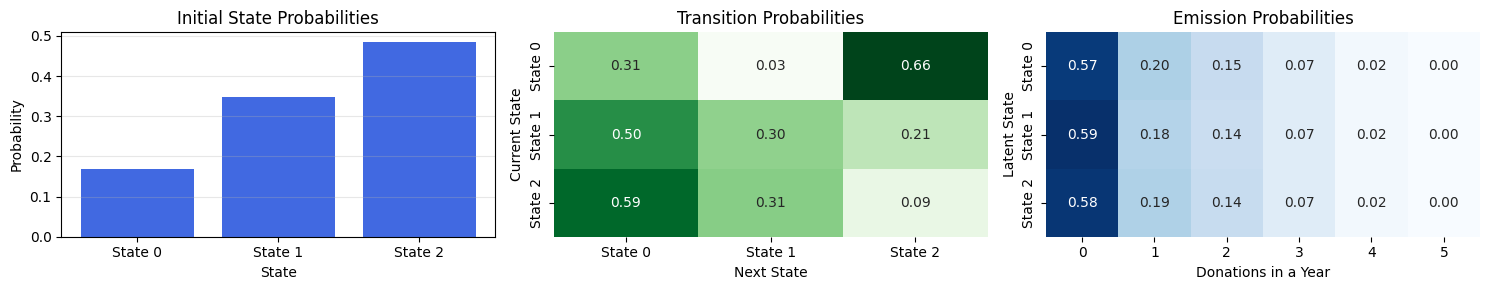

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_hmm_params(transitions, initial_probs, emissions,
                    state_names=None, emission_names=None):
    """
    Plotta in una riga:
    - Matrice di transizione [S, S]
    - Prob iniziali [S]
    - Matrice emissioni [S, K]
    """
    S = len(initial_probs)
    K = emissions.shape[1]
    if state_names is None:
        state_names = [f"State {i}" for i in range(S)]
    if emission_names is None:
        emission_names = [str(i) for i in range(K)]

    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    # Initial probabilities
    axs[0].bar(np.arange(S), initial_probs, color='royalblue')
    axs[0].set_title('Initial State Probabilities')
    axs[0].set_xlabel('State')
    axs[0].set_ylabel('Probability')
    axs[0].set_xticks(np.arange(S))
    axs[0].set_xticklabels(state_names)
    axs[0].grid(axis='y', alpha=0.3)

    # Transition matrix
    sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Greens',
                xticklabels=state_names, yticklabels=state_names, ax=axs[1], cbar=False)
    axs[1].set_title('Transition Probabilities')
    axs[1].set_xlabel('Next State')
    axs[1].set_ylabel('Current State')

    # Emission probabilities/matrix
    sns.heatmap(emissions, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=emission_names, yticklabels=state_names, ax=axs[2], cbar=False)
    axs[2].set_title('Emission Probabilities')
    axs[2].set_xlabel('Donations in a Year')
    axs[2].set_ylabel('Latent State')

    plt.tight_layout()
    plt.show()

# Plot the learned parameters
plot_hmm_params(
    transitions=trans_probs,
    initial_probs=init_probs,
    emissions=emission_probs)

State occupancy over time (population view)

In [13]:
# Viterbi or posterior-sample paths: paths -> (N,T) ints
counts = np.apply_along_axis(lambda col: np.bincount(col, minlength=K),
                             0, paths)          # (K,T)
props  = counts / counts.sum(0, keepdims=True)

plt.figure(figsize=(8,4))
for k,c in enumerate(['tab:orange','tab:blue','tab:green']):
    plt.plot(props[k], label=f'state {k}', color=c)
plt.xlabel('year index'); plt.ylabel('population share')
plt.title('State occupancy over time'); plt.legend(); plt.tight_layout()

NameError: name 'paths' is not defined

In [14]:
flat_x = obs_torch.flatten().cpu().numpy()
flat_z = paths.flatten()
sns.violinplot(x=flat_z, y=flat_x, inner="quartile")
plt.xlabel('latent state'); plt.ylabel('# donations')
plt.title('Observed donations given latent state')

NameError: name 'paths' is not defined

## Full Pyro

### Poisson

In this section, unlike the previous approach, we explicitly define prior distributions for the HMM parameters (initial state, transition matrix, emission rates) using pyro.sample. The guide function introduces variational distributions (with learnable parameters) for these latent variables, enabling fully Bayesian inference via SVI. This allows us to incorporate prior knowledge and quantify uncertainty over the model parameters.

Model  
- 3-state Poisson Hidden Markov Model.  

  $$\pi \sim \text{Dirichlet}(\mathbf 1)$$  
  $$A_{k\cdot} \sim \text{Dirichlet}(\mathbf 1)\quad\forall k$$  
  $$z_0 \sim \text{Categorical}(\pi),\qquad 
    z_t\mid z_{t-1}\sim\text{Categorical}(A_{z_{t-1}\cdot})$$  
  $$\lambda_k \sim \text{Gamma}(2,1)$$  
  $$y_t \mid z_t=k \sim \text{Poisson}(\lambda_k)$$  

  Discrete chains $z_{n,t}$ are marginalised exactly via enumeration.

Guide (mean-field)  
  $$q(\pi)=\text{Dirichlet}(\boldsymbol{\alpha}_\pi),\qquad 
    q(A_{k\cdot})=\text{Dirichlet}(\boldsymbol{\alpha}_{A_k}),\qquad
    q(\lambda_k)=\text{Gamma}(\alpha_k,\beta_k)$$  

  Hence $$q(\pi,A,\lambda)=q(\pi)\prod_k q(A_{k\cdot})q(\lambda_k)$$ with no cross-covariances; $z$’s remain exact.

Training  
- Stochastic Variational Inference, Adam (lr = 0.05).  
- Objective: TraceEnum_ELBO(max_plate_nesting = 1).  
- ELBO descends from ≈174 k to ≈130 k; posterior means $\hat\pi$, $\hat A$, $\hat\lambda$ are reported together with their Dirichlet/Gamma uncertainty. 

In [ ]:
obse

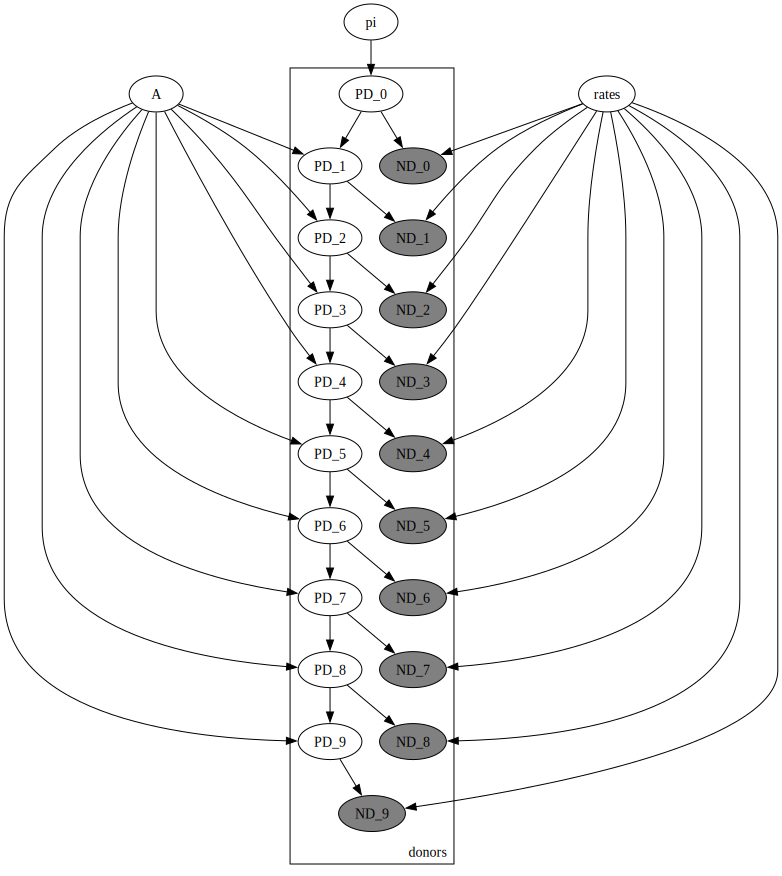

In [25]:
def model(observations):
    
    N, T = observations.shape
    num_states = 3


# ------------------------------------------------------------------ #
#  MODEL                                                             #
# ------------------------------------------------------------------ #
def model(obs):
    N, T = obs.shape

    # π   (prob. iniziali)  – una sola Dirichlet
    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(K)))              # [K]

    # A   (matrice di transizione)  – K Dirichlet, una per riga
    with pyro.plate("row", K):
        A = pyro.sample("A", dist.Dirichlet(torch.ones(K)))            # [K,K]

    # tassi Poisson
    rates = pyro.sample("rates",
                        dist.Gamma(2.*torch.ones(K),
                                   1.*torch.ones(K)).to_event(1))      # [K]

    # osservazioni
    with pyro.plate("donor", N):
        z = pyro.sample("z_0", dist.Categorical(pi),
                        infer={"enumerate": "parallel"})

    with pyro.plate("donors", N):
        # primo stato PD_0
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        y = pyro.sample(f"ND_{0}", dist.Poisson(rates[x]), obs=observations[:, 0])
        
        for t in pyro.markov(range(T-1)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            y = pyro.sample(f"ND_{t+1}", dist.Poisson(rates[x]), obs=observations[:, t+1])
    return y        


fake_obs = torch.zeros(5, 10)  # 5 individui, 10 osservazioni temporali
pyro.render_model(model, model_args=(fake_obs,))

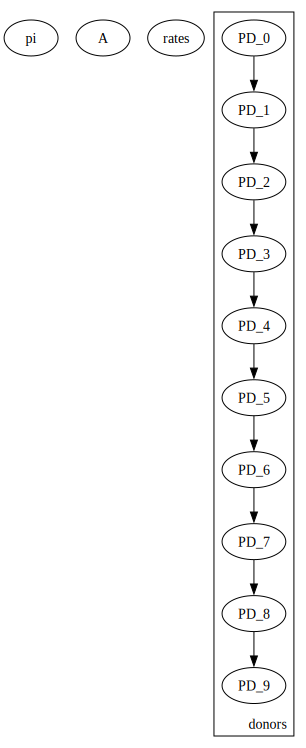

In [51]:
import torch.nn.functional as F

def guide(observations):
    N, T = observations.shape
    K = 3
    
    # guide optimizable parameters
    pi_alpha = pyro.param("pi_alpha", torch.ones(K), constraint=dist.constraints.positive)
    
    A_alpha = pyro.param("A_alpha", torch.ones(K, K), constraint=dist.constraints.positive)
    
    rates_alpha = pyro.param("rates_alpha", 2.0 * torch.ones(K), constraint=dist.constraints.positive)
    rates_beta = pyro.param("rates_beta", torch.ones(K), constraint=dist.constraints.positive)
    
    # pi_alpha = pyro.param("pi_alpha", torch.tensor([2.0, 1.0, 0.5]), constraint=dist.constraints.positive)
    # rates_alpha = pyro.param("rates_alpha", torch.tensor([4.0, 2.0, 1.0]), constraint=dist.constraints.positive)

    pi = pyro.sample("pi", dist.Dirichlet(pi_alpha))
    A = pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))
    rates = pyro.sample("rates", dist.Gamma(rates_alpha, rates_beta).to_event(1))


        # --- Guida per catene latenti Z_i con struttura Markov ---
    with pyro.plate("donors", N):
        # q(Z_0) - iniziale
        z0_logits = pyro.param("z0_logits", torch.randn(N, K))
        z_prev = pyro.sample("PD_0", dist.Categorical(logits=z0_logits), infer={"enumerate": "parallel"})

        for t in range(1, T):
            # Logits per q(Z_t) come prodotto tra one-hot di Z_{t-1} e matrice A (parametrizzata)
            # per far dipendere q(Z_t) da q(A)
            A_logits = pyro.param(f"A_logits_{t}", torch.randn(K, K))  # parametri liberi da ottimizzare

            # Prendiamo il vettore one-hot di z_prev per ogni donatore
            z_prev_onehot = F.one_hot(z_prev, num_classes=K).float()  # shape [N, K]

            # Calcoliamo logits per Z_t come prodotto: [N,K] x [K,K] = [N,K]
            logits_t = torch.matmul(z_prev_onehot, A_logits)

            z_prev = pyro.sample(f"PD_{t}", dist.Categorical(logits=logits_t), infer={"enumerate": "parallel"})

    return pi, A, rates 

# This doesn't make much sense, but it's just to show the guide
pyro.render_model(guide, model_args=(fake_obs,))

In [52]:
from tqdm.notebook import tqdm
from pyro.optim import ClippedAdam

pyro.clear_param_store()  # resetta tutti i parametri!

STEPS = 4000 # optimization steps
optimizer = ClippedAdam({'lr': 0.05})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)

loss = np.zeros(STEPS)
for step in tqdm(range(STEPS)):
    loss[step] = svi.step(obs_torch)
    if step % 20 == 0:
        print(f"Step {step} loss: {loss[step]}")

  0%|          | 0/4000 [00:00<?, ?it/s]

Step 0 loss: 429579.8125
Step 20 loss: 359233.625
Step 40 loss: 239818.9375
Step 60 loss: 310995.875
Step 80 loss: 205768.390625
Step 100 loss: 265983.75
Step 120 loss: 302671.40625
Step 140 loss: 241667.078125
Step 160 loss: 187880.484375
Step 180 loss: 244581.859375
Step 200 loss: 195797.59375
Step 220 loss: 217561.421875
Step 240 loss: 229112.359375
Step 260 loss: 204452.71875
Step 280 loss: 259973.890625
Step 300 loss: 243775.59375
Step 320 loss: 258646.421875
Step 340 loss: 273878.03125
Step 360 loss: 290300.4375
Step 380 loss: 227208.140625
Step 400 loss: 196005.9375
Step 420 loss: 267286.25
Step 440 loss: 221732.78125
Step 460 loss: 230466.46875
Step 480 loss: 327579.53125
Step 500 loss: 254855.9375
Step 520 loss: 200608.4375
Step 540 loss: 240581.90625
Step 560 loss: 239384.65625
Step 580 loss: 203492.75
Step 600 loss: 202450.21875
Step 620 loss: 252236.28125
Step 640 loss: 202023.765625
Step 660 loss: 198059.03125
Step 680 loss: 300191.46875
Step 700 loss: 189134.484375
Step 7

KeyboardInterrupt: 

In [ ]:
# dict(pyro.get_param_store())

In [19]:
• ELBO steadily decreases from ≈174 k to ≈130 k and then plateaus → optimisation has mostly converged.

pi_learn = dist.Dirichlet(torch.tensor(learned_pi))
A_learn = dist.Dirichlet(torch.tensor(learned_A))  # attenzione alla to_event
rates_learn = dist.Gamma(torch.tensor(learned_rates_alpha), torch.tensor(learned_rates_beta))

pi_mean = pi_learn.mean
A_mean = A_learn.mean
rates_mean = rates_learn.mean

print("Initial state probabilities (normalized):", pi_mean)
print("Transition matrix (normalized):", A_mean)
print("Poisson rates:", rates_mean)

Initial state probabilities (normalized): tensor([0.2667, 0.6157, 0.1176])
Transition matrix (normalized): tensor([[0.9212, 0.0276, 0.0512],
        [0.0840, 0.7815, 0.1345],
        [0.0921, 0.0595, 0.8484]])
Poisson rates: tensor([1.0281, 0.0309, 1.4052])


In [21]:
def build_emission_matrix(rates, max_k=4):
    S = len(rates)
    K = max_k + 1   # da 0 a max_k incluso
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k+1):
            emissions[s, k] = poisson.pmf(k, rates[s])
        #  L'ultimo raccoglie la coda (tutto >= max_k)
        # emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
    return emissions

emissions_matrix = build_emission_matrix(rates_mean, max_k=4)

print(f"Emission matrix (not normalized):\n {emissions_matrix}")

Emission matrix (not normalized):
 [[3.57683952e-01 3.67736838e-01 1.89036132e-01 6.47830289e-02
  1.66509470e-02]
 [9.69617887e-01 2.99158297e-02 4.61499772e-04 4.74625066e-06
  3.66092737e-08]
 [2.45309769e-01 3.44717506e-01 2.42204294e-01 1.13451196e-01
  3.98563555e-02]]


In [ ]:
# learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
# learned_A = pyro.param("A_alpha").detach().cpu().numpy()
# learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
# learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()

# pi_norm = learned_pi / learned_pi.sum()
# A_norm = learned_A / learned_A.sum()  # conto sbagliato!
# rates_norm = learned_rates_alpha / learned_rates_beta

# print("Learned initial state probabilities (normalized):", pi_norm)
# print("Learned transition matrix (normalized):", A_norm)
# print("Learned Poisson rates (normalized):", rates_norm)



In [ ]:
# def build_emission_matrix_truncated_poisson(rates, max_k=4):
#     S = len(rates)
#     K = max_k + 1   # da 0 a max_k incluso
#     emissions = np.zeros((S, K))
#     for s in range(S):
#         for k in range(max_k):
#             emissions[s, k] = poisson.pmf(k, rates[s])
#         #  L'ultimo raccoglie la coda (tutto >= max_k)
#         emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
#     return emissions

# emissions_matrix = build_emission_matrix_truncated_poisson(rates_norm, max_k=4)

# emissions_matrix

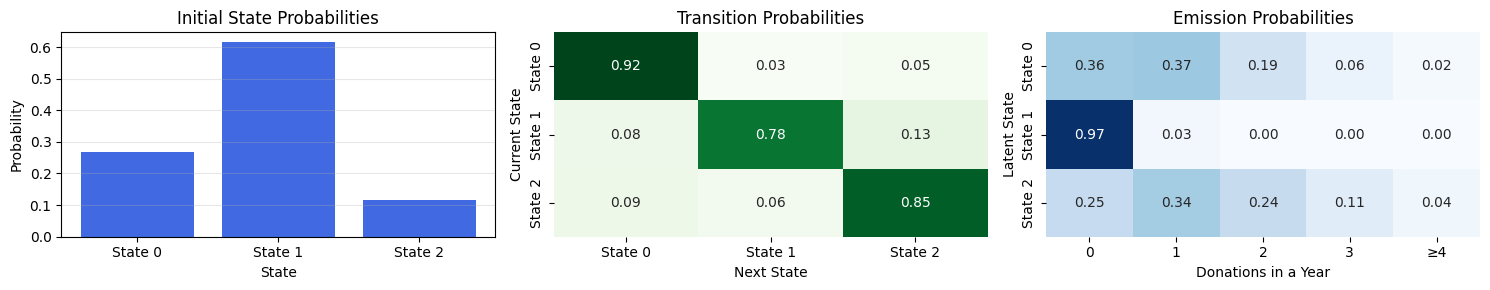

In [22]:
plot_hmm_params(
    transitions=A_mean,
    initial_probs=pi_mean,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

In [47]:
def generative_model(pi, A, rates, N=9000, T=15):
    with pyro.plate("donors", N):
        print(f"pi: {pi}, A: {A}, rates: {rates}")
        x = pyro.sample("PD_0", dist.Categorical(pi))
        y = [pyro.sample(f"ND_0", dist.Poisson(rates[x]))]
        for t in range(1, T):
            x = pyro.sample(f"PD_{t}", dist.Categorical(A[x]))
            y.append(pyro.sample(f"ND_{t}", dist.Poisson(rates[x])))
    return torch.stack(y, dim=1)  # shape: [N, T]

In [48]:
y_sim = generative_model(pi_learn.sample(), A_learn.sample(), rates_learn.sample())  # nuove catene simulate

y_sim.shape

pi: tensor([0.6734, 0.2826, 0.0440]), A: tensor([[9.5665e-01, 4.2409e-02, 9.4312e-04],
        [4.7461e-03, 8.1622e-01, 1.7903e-01],
        [3.0956e-03, 4.4691e-02, 9.5221e-01]]), rates: tensor([0.8875, 0.0032, 0.6801])


torch.Size([9000, 15])

Osservazioni al tempo t=0:


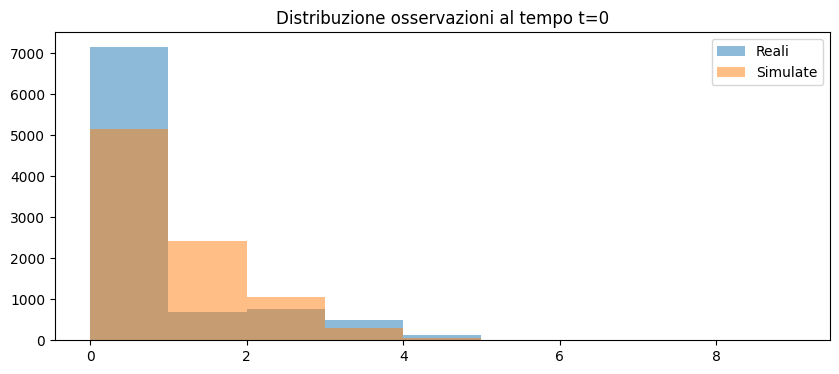

Osservazioni al tempo t=1:


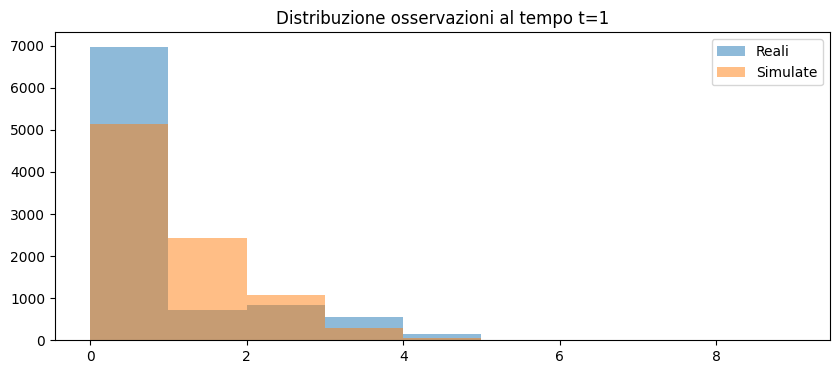

Osservazioni al tempo t=2:


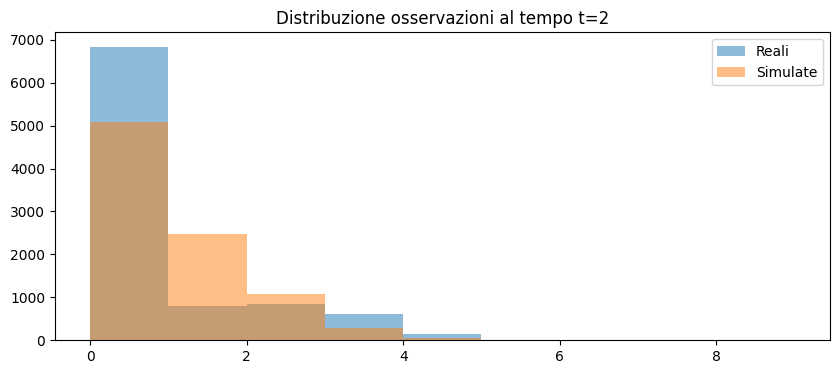

Osservazioni al tempo t=3:


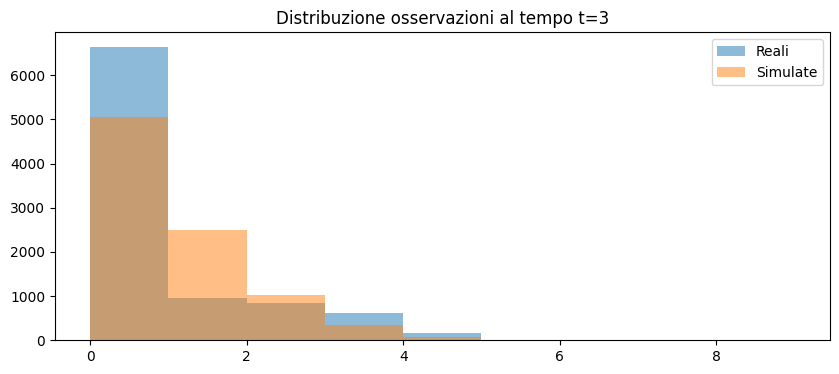

Osservazioni al tempo t=4:


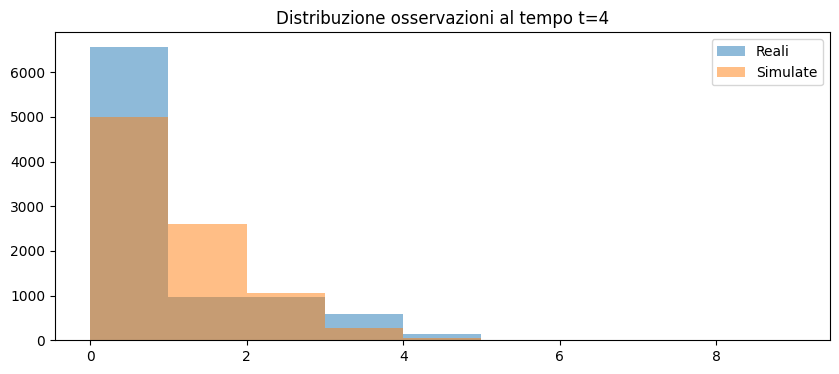

Osservazioni al tempo t=5:


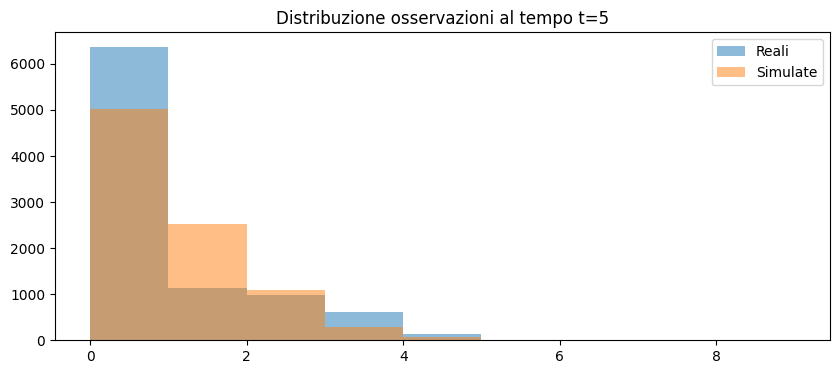

Osservazioni al tempo t=6:


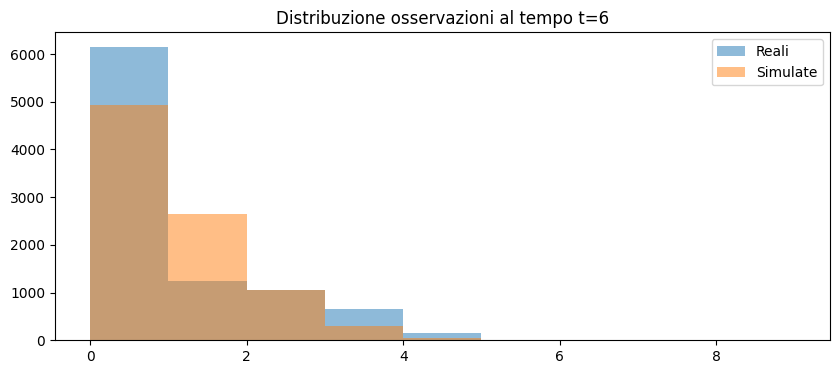

Osservazioni al tempo t=7:


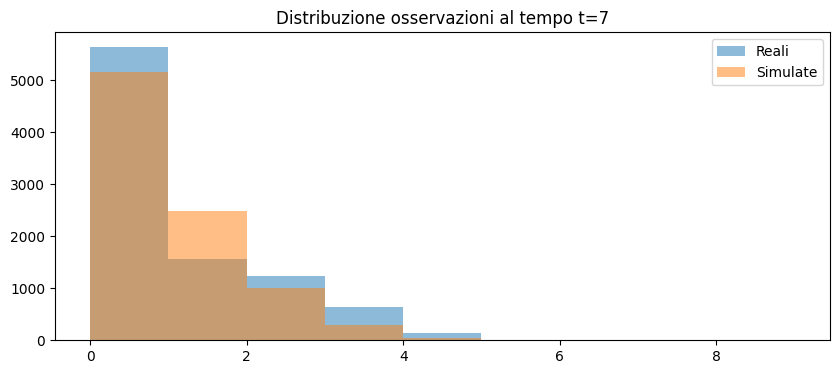

Osservazioni al tempo t=8:


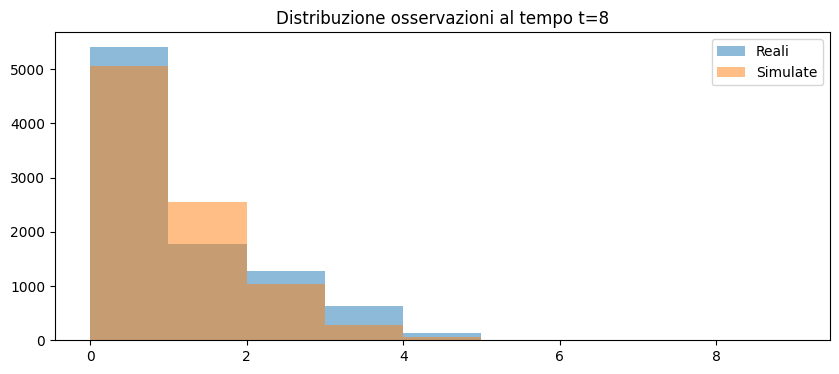

Osservazioni al tempo t=9:


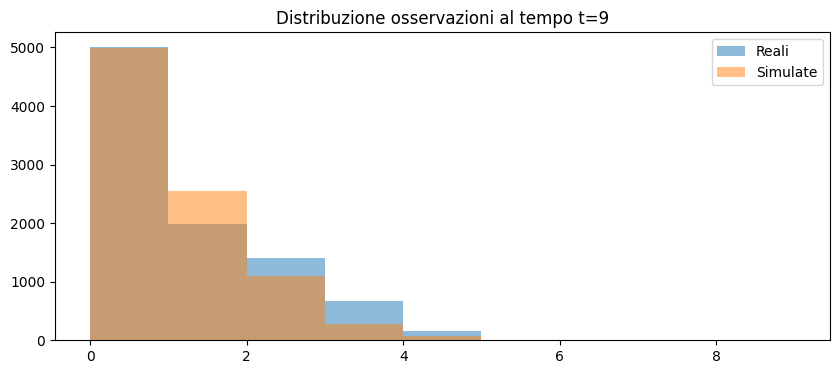

Osservazioni al tempo t=10:


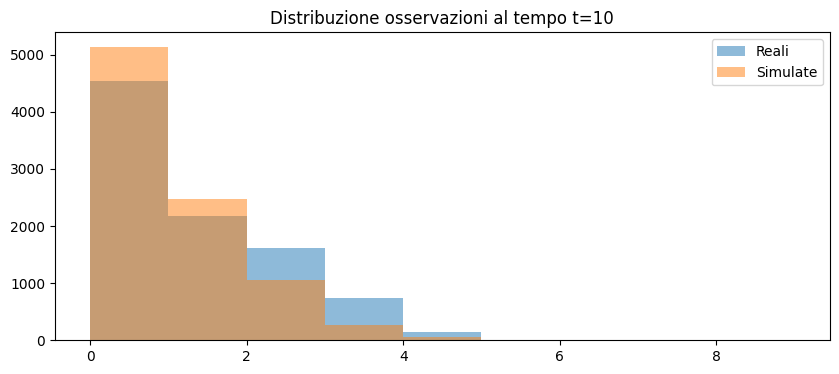

Osservazioni al tempo t=11:


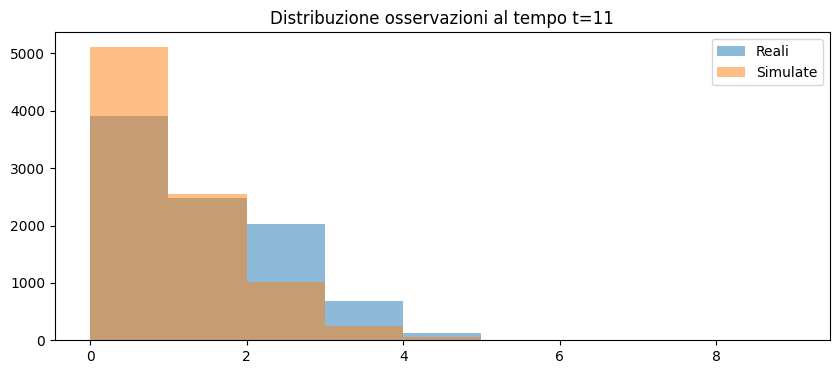

Osservazioni al tempo t=12:


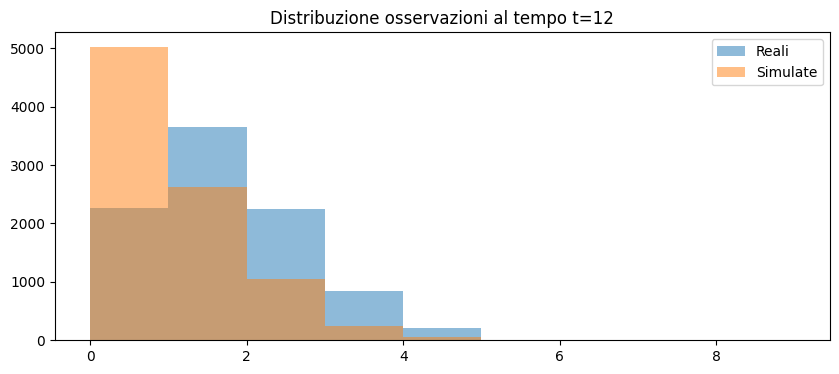

Osservazioni al tempo t=13:


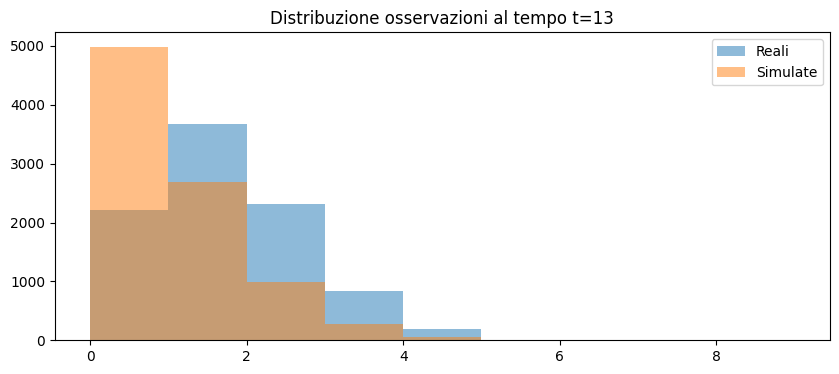

Osservazioni al tempo t=14:


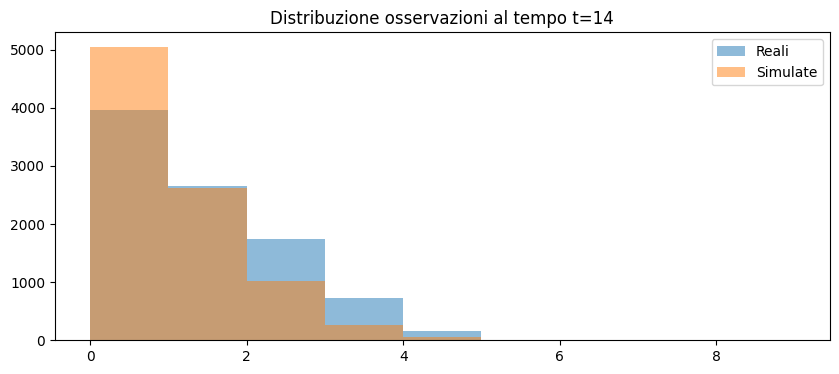

In [49]:
T = obs_torch.shape[1]

for t in range(T):
    print(f"Osservazioni al tempo t={t}:")
    plt.figure(figsize=(10, 4))
    plt.hist(obs_torch[:, t].numpy(), bins=range(0, 10), alpha=0.5, label='Reali')
    plt.hist(y_sim[:, t].numpy(), bins=range(0, 10), alpha=0.5, label='Simulate')
    plt.title(f'Distribuzione osservazioni al tempo t={t}')
    plt.legend()
    plt.show()

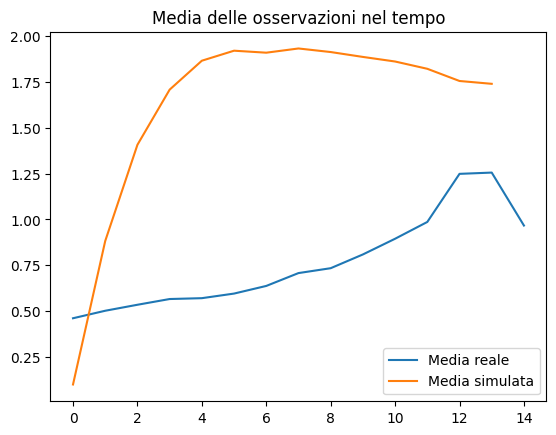

In [42]:
mean_real = obs_torch.float().mean(dim=0)
mean_sim = y_sim.float().mean(dim=0)

plt.plot(mean_real, label='Media reale')
plt.plot(mean_sim, label='Media simulata')
plt.title('Media delle osservazioni nel tempo')
plt.legend()
plt.show()

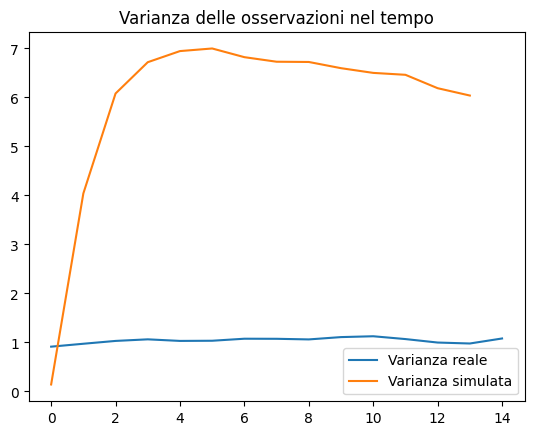

In [43]:
var_real = obs_torch.float().var(dim=0)
var_sim = y_sim.float().var(dim=0)

plt.plot(var_real, label='Varianza reale')
plt.plot(var_sim, label='Varianza simulata')
plt.title('Varianza delle osservazioni nel tempo')
plt.legend()
plt.show()

#### Viterbi algorithm

Viterbi decoder  
Goal : for each donor find the MAP latent path $z_{0:T}^\ast$.  

Plug-in parameters (posterior means)  
$$\hat\pi_k = \frac{\alpha_{\pi,k}}{\sum_{j}\alpha_{\pi,j}},\qquad
  \hat A_{kj} = \frac{\alpha_{A_{k j}}}{\sum_{j'}\alpha_{A_{k j'}}},\qquad
  \hat\lambda_k = \frac{\alpha_k}{\beta_k}.$$

Dynamic programming  
Initial step  
$$\delta_0(k)=\log\hat\pi_k+\log\text{Poisson}(y_0\mid\hat\lambda_k).$$  

Recursion for $t=1,\dots,T$  
$$\delta_t(j)=\max_k\bigl[\delta_{t-1}(k)+\log\hat A_{k j}\bigr]
               +\log\text{Poisson}(y_t\mid\hat\lambda_j),$$  
$$\psi_t(j)=\arg\max_k\bigl[\delta_{t-1}(k)+\log\hat A_{k j}\bigr].$$  

Back-tracking  
Start with $z_T^\ast=\arg\max_k\delta_T(k)$, then  
$z_{t-1}^\ast=\psi_t(z_t^\ast)$ for $t=T,\dots,1$.

Cost $O(NTK^2)$ but vectorised in PyTorch, so only a loop on $t$.  
Output tensor paths[N,T] of integers 0…K-1, used for diagnostics and plots. 

In [17]:
def viterbi_paths_poisson(obs,      # LongTensor [N,T]
                          K=3):     # # latent states
    """
    Returns the most-likely latent path for every individual
    using the current variational parameters of the Poisson HMM.
    """
    with torch.no_grad():
        # ----- expected model parameters ---------------------------------
        # initial probs π
        pi_alpha = pyro.param("pi_alpha")                  # [K]
        pi_prob  = pi_alpha / pi_alpha.sum()               # [K]
        log_pi   = pi_prob.log()

        # transition matrix A
        A_alpha  = pyro.param("A_alpha")                   # [K,K]
        A_prob   = A_alpha / A_alpha.sum(1, keepdim=True)  # rows sum 1
        log_A    = A_prob.log()

        # Poisson rates λ
        r_alpha  = pyro.param("r_alpha")                   # [K]
        r_beta   = pyro.param("r_beta")
        rates    = r_alpha / r_beta                       # [K]

        # ----- pre-compute emission log-probs ----------------------------
        N, T = obs.shape
        emis_log = dist.Poisson(rates).log_prob(obs.unsqueeze(-1))  # (N,T,K)

        # ----- Viterbi ----------------------------------------------------
        paths  = torch.zeros(N, T, dtype=torch.long)
        psi    = torch.zeros(N, T, K, dtype=torch.long)   # back-pointers
        delta  = log_pi + emis_log[:, 0]                  # (N,K)

        for t in range(1, T):
            # score: delta_prev + log A (broadcast prev→next)
            score = delta.unsqueeze(2) + log_A            # (N,K_prev,K_next)
            delta, psi[:, t] = torch.max(score, dim=1)    # argmax over prev
            delta += emis_log[:, t]                       # add emission

        # back-tracking
        last = torch.argmax(delta, dim=1)                 # (N,)
        paths[:, -1] = last
        for t in range(T - 1, 0, -1):
            last = psi[torch.arange(N), t, last]
            paths[:, t-1] = last

    return paths


# -------------------------------------------------------------------------
paths = viterbi_paths_poisson(obs_torch, K=3).cpu().numpy()

# e.g. fraction of sequences that switch state at least once
switch = (paths[:, 1:] != paths[:, :-1]).any(1).mean()
print(f"Sequences with ≥1 switch: {switch * 100:.1f}%")

Sequences with ≥1 switch: 80.3%


##### State occupancy over time (population view)

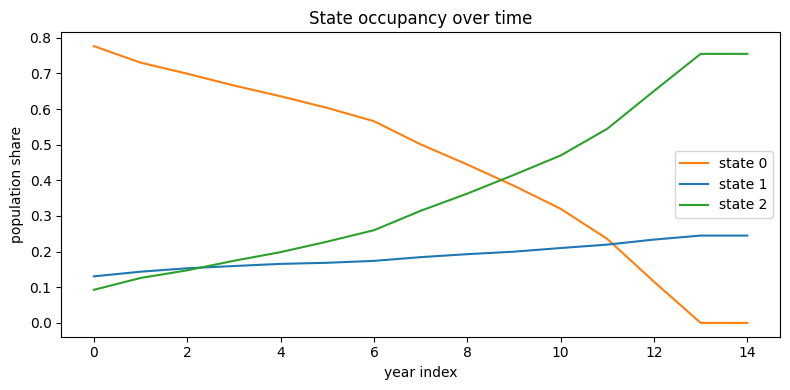

In [18]:
counts = np.apply_along_axis(lambda col: np.bincount(col, minlength=3),
                             0, paths)          # (K,T)
props  = counts / counts.sum(0, keepdims=True)

plt.figure(figsize=(8,4))
for k,c in enumerate(['tab:orange','tab:blue','tab:green']):
    plt.plot(props[k], label=f'state {k}', color=c)
plt.xlabel('year index'); plt.ylabel('population share')
plt.title('State occupancy over time'); plt.legend(); plt.tight_layout()

##### Rates with confidence bands

Text(0.5, 1.0, 'Poisson rates with 95% CI')

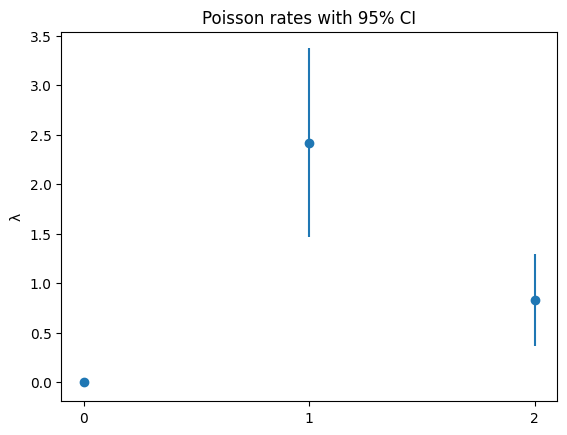

In [25]:

rate_sd   = np.sqrt(pyro.param("r_alpha").detach().numpy()) / pyro.param("r_beta").detach().numpy()
ci = 1.96 * rate_sd
plt.errorbar(np.arange(K), rates, yerr=ci, fmt='o')
plt.xticks(range(K)); plt.ylabel('λ'); plt.title('Poisson rates with 95% CI')

##### Network / chord diagram of transitions

A visual alternative to the heat-map, highlights main flows.

C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


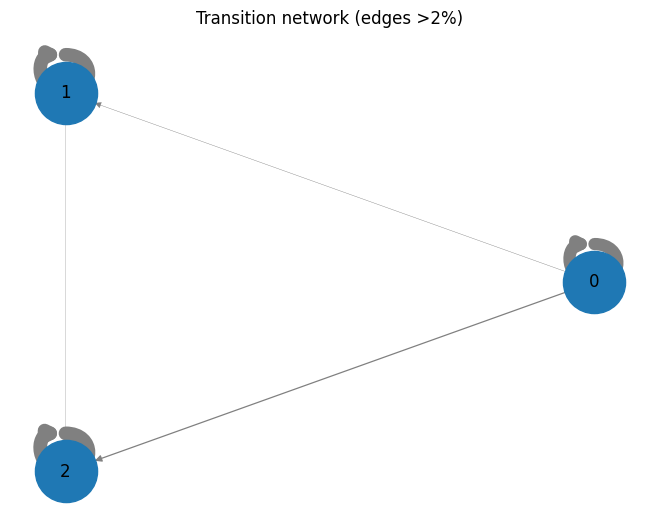

In [26]:
import networkx as nx
G = nx.DiGraph()
for i in range(K):
    for j in range(K):
        if A_mean[i,j] > 0.02:                 # ignore tiny flows
            G.add_edge(i, j, weight=A_mean[i,j])
pos = nx.circular_layout(G)
weights = [G[u][v]['weight']*10 for u,v in G.edges]
nx.draw(G, pos, with_labels=True, width=weights,
        edge_color='grey', node_size=2000, cmap='viridis')
plt.title('Transition network (edges >2%)'); plt.show()

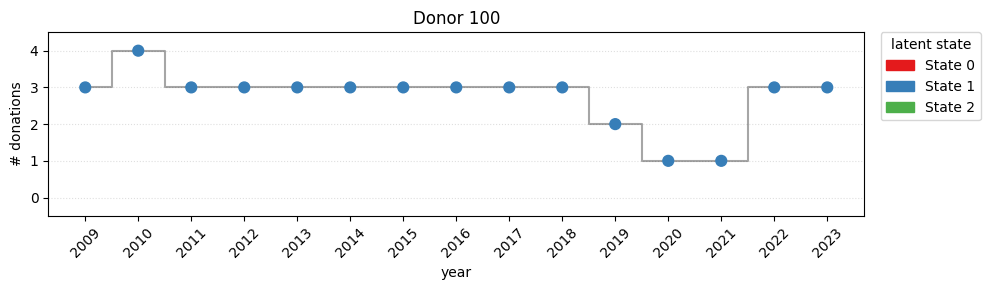

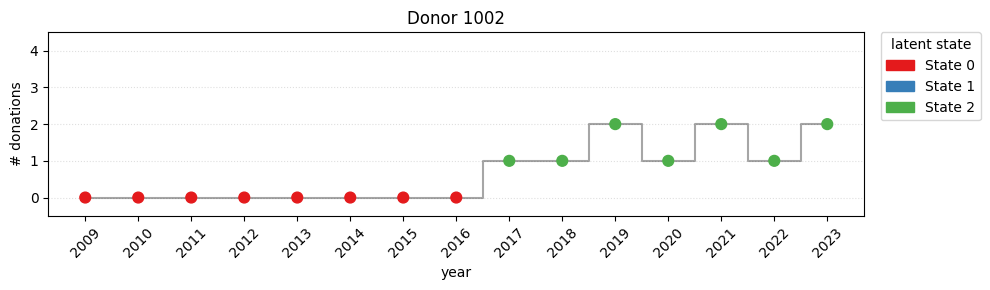

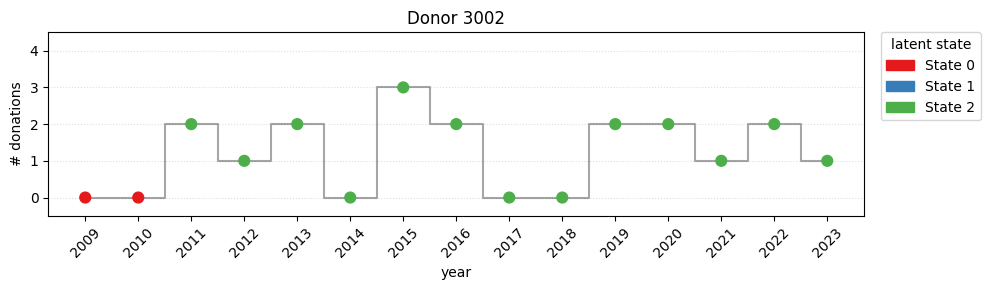

In [44]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import numpy as np

# ------------------------------------------------------------
# globals
# ------------------------------------------------------------
K           = 3
state_cols  = ['#e41a1c', '#377eb8', '#4daf4a']          # 3 colori Set1
cmap        = ListedColormap(state_cols)
norm        = BoundaryNorm(np.arange(-0.5, K+0.5, 1), cmap.N)
years_axis  = np.arange(2009, 2024)                      # 2009 .. 2024
yticks_vals = np.arange(0, 5)                            # 0 .. 4

# ------------------------------------------------------------
def plot_one(idx):
    x = obs_torch[idx].cpu().numpy()       # osservazioni (T,)
    z = paths[idx]                         # stati latenti (T,)
    T = len(x)
    assert T == len(years_axis), "years_axis length must match T"

    plt.figure(figsize=(10, 3))
    plt.scatter(range(T), x, c=z, cmap=cmap, norm=norm, s=60, zorder=3)
    plt.step(range(T), x, where='mid', color='k', alpha=.35, zorder=2)

    # ---------- axis formatting ----------------------------------------
    plt.xticks(ticks=range(T), labels=years_axis, rotation=45)
    plt.yticks(ticks=yticks_vals)
    plt.ylim(-0.5, 4.5)                     # blocca a 0–4
    plt.grid(axis='y', linestyle=':', alpha=.4, zorder=1)

    # ---------- legenda discreta ---------------------------------------
    handles = [Patch(color=state_cols[k], label=f'State {k}') for k in range(K)]
    plt.legend(handles=handles, title='latent state',
               bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    plt.title(f'Donor {idx}')
    plt.xlabel('year')
    plt.ylabel('# donations')
    plt.tight_layout()
    plt.show()


for i in [100, 1002, 3002]:
    plot_one(i)

##### Stationary distribution vs initial π

Compute the stationary distribution of A and plot both as bars.

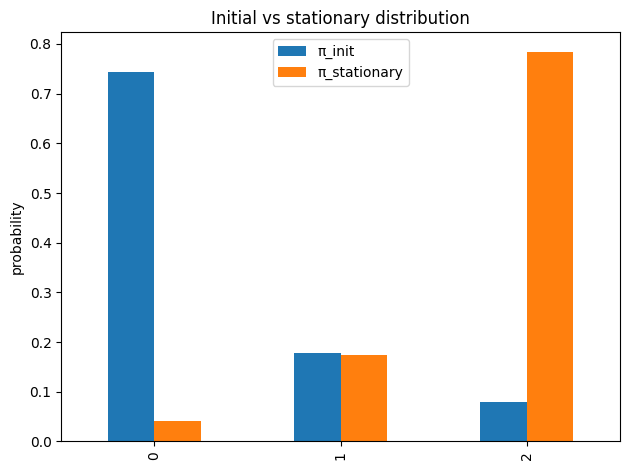

In [39]:
w, v = np.linalg.eig(A_mean.T)
stationary = np.real(v[:,np.isclose(w,1)].flatten())
stationary /= stationary.sum()
df = pd.DataFrame({'π_init':pi_mean, 'π_stationary':stationary})
df.plot(kind='bar'); plt.ylabel('probability')
plt.title('Initial vs stationary distribution'); plt.tight_layout()

### Testing

Actually, this model is the best one, looking the loss. Maybe for the prior 

In [ ]:
def generate_simulated_data(T, n_series):
    pi = pyro.param("pi_alpha")
    A = pyro.param("A_alpha")
    rates_alpha = pyro.param("rates_alpha")
    rates_beta = pyro.param("rates_beta")

    q_pi = dist.Dirichlet(pi)
    q_A = dist.Dirichlet(A)
    q_rates = dist.Gamma(rates_alpha, rates_beta)

    pi_sample = q_pi.mean
    A_sample = q_A.mean
    rates_sample = q_rates.mean

    simulated = []
    for _ in range(n_series):
        _, y = sample_sequence(T, pi_sample, A_sample, rates_sample)
        simulated.append(y)
    
    return torch.stack(simulated)

In [ ]:
# Dati finti, gli do una prior per fare testing
pi_true = torch.tensor([[0.00198279, 0.14994904, 0.84806824]])
A_true = torch.tensor([[1.4430614e-01, 1.8874713e-04, 1.1168744e-03],
 [8.4352428e-03, 2.5033113e-01, 4.1714776e-04],
 [5.7374258e-02, 1.8518262e-02, 5.1931220e-01]])
rates_true = torch.tensor([0.780297,   2.0785418,  0.00218539])
states = [torch.multinomial(pi_true, 1).item()]

def model(observations):
    N, T = observations.shape
    num_states = 3
    
    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    rates = pyro.sample("rates", dist.Gamma(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))
    
    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"ND_{t}", dist.Poisson(rates[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    rates_alpha = pyro.param("rates_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    rates_beta = pyro.param("rates_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))  
    pyro.sample("rates", dist.Gamma(rates_alpha, rates_beta).to_event(1))

pyro.clear_param_store()  # resetta tutti i parametri!

optimizer = Adam({"lr": .10})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)

for step in range(2_000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Step {step}, loss: {loss}")

In [ ]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("rates_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("rates_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Normalize the values

In [ ]:
pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", learned_rates_alpha / learned_rates_beta)

In [ ]:
plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=build_emission_matrix_truncated_poisson(rates_norm, max_k=4),
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Geometric

In this section, we use a Geometric distribution for the emission probabilities instead of a Poisson. Both distributions can model count data, but with different interpretations: the Poisson models the total number of events in a fixed period, while the Geometric models the number of trials until the first success.
However, in our dataset, the observed data are yearly donation counts ranging from 0 to 4. Using a Geometric emission can provide a different latent structure compared to the Poisson, but it is less natural for bounded count data, since the Geometric is unbounded above. This choice mainly affects how the HMM explains the observed counts and the interpretation of the latent states.

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam

def model(observations):
    N, T = observations.shape
    num_states = 3

    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_states)))
    A = pyro.sample("A", dist.Dirichlet(torch.ones(num_states, num_states)).to_event(1))
    probs = pyro.sample("probs", dist.Beta(2.0 * torch.ones(num_states), torch.ones(num_states)).to_event(1))

    with pyro.plate("donors", N):
        x = pyro.sample("PD_0", dist.Categorical(pi), infer={"enumerate": "parallel"})
        for t in pyro.markov(range(T)):
            x = pyro.sample(f"PD_{t+1}", dist.Categorical(A[x]), infer={"enumerate": "parallel"})
            pyro.sample(f"y_{t}", dist.Geometric(probs[x]), obs=observations[:, t])

def guide(observations):
    num_states = 3
    pi_alpha = pyro.param("pi_alpha", torch.ones(num_states), constraint=dist.constraints.positive)
    A_alpha = pyro.param("A_alpha", torch.ones(num_states, num_states), constraint=dist.constraints.positive)
    probs_alpha = pyro.param("probs_alpha", 2.0 * torch.ones(num_states), constraint=dist.constraints.positive)
    probs_beta = pyro.param("probs_beta", torch.ones(num_states), constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))
    pyro.sample("A", dist.Dirichlet(A_alpha).to_event(1))
    pyro.sample("probs", dist.Beta(probs_alpha, probs_beta).to_event(1))

pyro.clear_param_store()  # resetta tutti i parametri!

optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))

# pyro.render_model(model, model_args=(obs_torch,), render_distributions=False)


for step in range(2_000):
    loss = svi.step(obs_torch)
    if step % 200 == 0:
        print(f"Step {step} loss: {loss}")

In [ ]:
learned_pi = pyro.param("pi_alpha").detach().cpu().numpy()
learned_A = pyro.param("A_alpha").detach().cpu().numpy()
learned_rates_alpha = pyro.param("probs_alpha").detach().cpu().numpy()
learned_rates_beta = pyro.param("probs_beta").detach().cpu().numpy()


pi_norm = learned_pi / learned_pi.sum()
A_norm = learned_A / learned_A.sum()
rates_norm = learned_rates_alpha / learned_rates_beta

print("Initial state probabilities (normalized):", pi_norm)
print("Transition matrix (normalized):", A_norm)
print("Poisson rates:", rates_norm)

Most people start in state 2, which is expected since some individuals begin donating later or were not eligible to donate due to their age. The transition matrix shows that individuals in state 2 tend to move to state 0 or 1. Once they reach state 0 or 1, donors tend to maintain their donation behavior. State 1 appears to be the most populated, likely representing occasional donors, while state 0 can be interpreted as the state of frequent donors.

In [ ]:
import numpy as np
from scipy.stats import geom

def build_emission_matrix_truncated_geometric(rates, max_k=4):
    S = len(rates)
    K = max_k + 1  # da 0 a 4, 5 valori
    ps = 1 / (rates + 1)
    emissions = np.zeros((S, K))
    for s in range(S):
        # Geometric shiftata: geom.pmf(k+1, p)
        for k in range(max_k):
            emissions[s, k] = geom.pmf(k+1, ps[s])
        # L'ultimo raccoglie tutta la coda: P(y >= max_k)
        emissions[s, max_k] = 1 - geom.cdf(max_k, ps[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_geometric(rates_norm, max_k=4)

plot_hmm_params(
    transitions=A_norm,
    initial_probs=pi_norm,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

## Models with covariates

### Mixed Model

This is not any more a HMM but is a mixture model where each units has only one latent variable

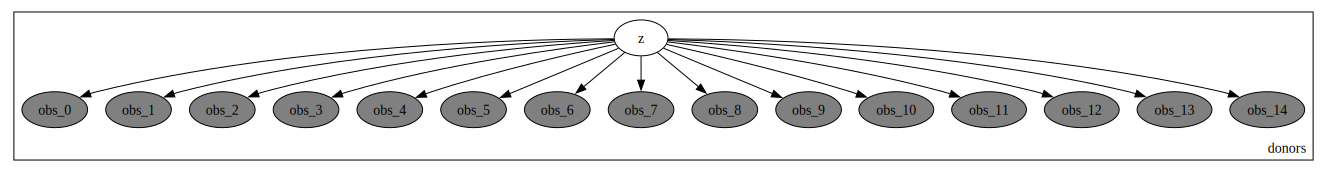

In [113]:
import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
import pyro.distributions.constraints as constraints

def model(observations, donors_covariates):
    N, T = observations.shape
    K = 3  # numero di stati latenti
    
    with pyro.plate("latent_params", K):
        rate = pyro.param("rate", torch.tensor([1.0, 3.0, 5.0]), constraint=constraints.positive)  # emission rate per stato
    
    # Probs statici per gli stati latenti (es: uniforme o funzione delle covariate)
    if donors_covariates is not None:
        C = donors_covariates.shape[2]
        W0 = pyro.param("W0", torch.ones(K, C))
        logits = torch.matmul(donors_covariates[:, 0, :], W0.T)  # [N, K]
        probs = torch.softmax(logits, dim=-1)
    else:
        probs = torch.ones(N, K) / K

    with pyro.plate("donors", N):
        z = pyro.sample("z", dist.Categorical(probs))  # stato latente per ciascun individuo

        for t in range(T):
            pyro.sample(f"obs_{t}", dist.Poisson(rate[z]), obs=observations[:, t])


pyro.render_model(model, model_args=(obs_torch, covariates_torch), render_distributions=False)

In [117]:
def guide(observations, donors_covariates):
    N, T = observations.shape
    K = 3
    C = donors_covariates.shape[2]

    W_q = pyro.param("W_q", torch.zeros(K, C))  # Parametri della guida
    logits_q = torch.matmul(donors_covariates[:, 0, :], W_q.T)  # [N, K]

    with pyro.plate("donors", N):
        pyro.sample("z", dist.Categorical(logits=logits_q))
    

In [118]:
from pyro.optim import ClippedAdam
from pyro.infer import SVI, Trace_ELBO
# Assumendo: observations_torch (N, T) e covariates_torch (N, C) siano tensor torch
pyro.clear_param_store()

optimizer = pyro.optim.Adam({"lr": 0.001})
elbo = Trace_ELBO()
svi = SVI(model, guide, optimizer, loss=elbo)

n_steps = 4000
for step in range(n_steps):
    loss = svi.step(obs_torch, covariates_torch)
    if step % 20 == 0:
        print(f"[{step}] Loss = {loss:.2f}")


[0] Loss = 356961.38
[200] Loss = 278638.26
[400] Loss = 233182.82
[600] Loss = 211068.99
[800] Loss = 195811.41
[1000] Loss = 187864.71
[1200] Loss = 181430.20
[1400] Loss = 177220.28
[1600] Loss = 175085.93
[1800] Loss = 172858.47
[2000] Loss = 170721.80
[2200] Loss = 170239.86
[2400] Loss = 169670.38
[2600] Loss = 168305.30
[2800] Loss = 168133.08
[3000] Loss = 167925.23
[3200] Loss = 167438.30
[3400] Loss = 166760.35
[3600] Loss = 166771.47
[3800] Loss = 166666.49


In [119]:
dict(pyro.get_param_store())

{'W_q': tensor([[ 1.2249,  1.3194, -0.9875],
         [-1.5014, -1.4319,  0.9849],
         [-0.0637, -1.1911,  0.9645]], requires_grad=True),
 'rate': tensor([0.5106, 1.1125, 1.1801], grad_fn=<AddBackward0>),
 'W0': tensor([[ 2.2635,  2.5797, -0.1039],
         [-0.3586, -0.0422,  1.9233],
         [ 1.0645,  0.1424,  1.8953]], requires_grad=True)}

In [ ]:
import numpy as np

# Estrai i parametri stimati
q_logits = pyro.param("q_logits").detach().cpu().numpy() # [N, K]
rate = pyro.param("rate").detach().cpu().numpy()  # [K]
W0 = pyro.param("W0").detach().cpu().numpy()      # [K, C]


(9236, 3)

In [49]:
# Calcola le probabilità iniziali medie sulla popolazione
logits = np.matmul(covariates_torch[:, 0, :].cpu().numpy(), W0.T)  # [N, K] 
probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True) # probabilità Z_n per ogni individuo n (normalizzata)

init_probs = probs.mean(axis=0)  # media sulle N persone

# Nessuna matrice di transizione in questo modello, puoi usare una matrice identità o None
transitions = np.eye(rate.shape[0])

In [21]:
# Costruisci la matrice di emissione Poisson come prima
def build_emission_matrix_truncated_poisson(rates, max_k=4):
    from scipy.stats import poisson
    S = len(rates)
    K = max_k + 1
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = poisson.pmf(k, rates[s])
        emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_poisson(rate, max_k=4)


Probabilità iniziali (media popolazione): [0.37057444 0.32560417 0.30382434]
Rate Poisson per stato: [0.71184295 0.77857846 0.81557   ]
Matrice di transizione (identità):
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


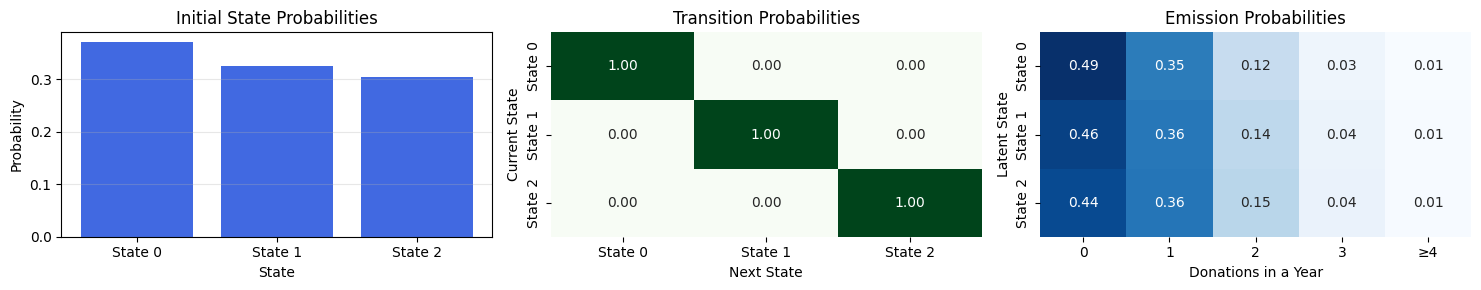

In [22]:
# Stampa i risultati numerici
print("Probabilità iniziali (media popolazione):", init_probs)
print("Rate Poisson per stato:", rate)
print("Matrice di transizione (identità):\n", transitions)

# Visualizza il grafico
plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

### Static Covariates

#### Poisson

tensor([ 0.3466, -1.3227,  0.7459], requires_grad=True)
tensor([[[ 0.2081, -0.8348, -0.4001],
         [-1.7025,  0.3265,  1.0028],
         [ 1.7034,  0.7902, -0.7185]],

        [[-2.0301,  1.4454,  1.7244],
         [ 1.6578, -0.6363, -1.3923],
         [ 0.4942, -0.6123, -0.6032]],

        [[-0.2891,  1.7266,  0.6572],
         [ 1.4466, -2.0682, -1.2983],
         [-0.5865,  0.3218,  0.1315]]], requires_grad=True)
tensor([[-1.3499,  0.3138,  1.1019],
        [ 1.6542,  0.0482, -1.5022],
        [ 2.0324, -1.1966, -1.4273]], requires_grad=True)
z_0 ---> x_0: tensor([0, 0, 2,  ..., 2, 0, 2]) tensor([0, 2, 4,  ..., 0, 0, 0]) osservazione reale: tensor([0, 2, 4,  ..., 0, 0, 0])
z_1 ---> x_1:  tensor([1, 1, 0,  ..., 0, 1, 1]) tensor([0, 1, 2,  ..., 0, 0, 0]) osservazione reale: tensor([0, 1, 2,  ..., 0, 0, 0])
z_2 ---> x_2:  tensor([0, 0, 1,  ..., 2, 0, 1]) tensor([0, 2, 3,  ..., 0, 0, 0]) osservazione reale: tensor([0, 2, 3,  ..., 0, 0, 0])
z_3 ---> x_3:  tensor([1, 1, 0,  ..., 1, 1,

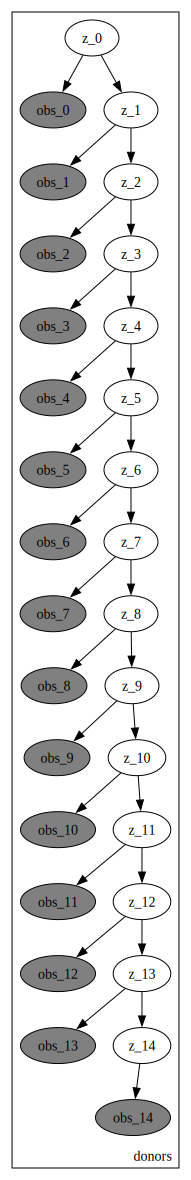

In [ ]:
def model(observations, donors_covariates):
    N, T = observations.shape
    K = 3
    C = donors_covariates.shape[2]

    rate = pyro.param("rate", torch.ones(K), constraint=constraints.positive)
    
    init_logits = pyro.param("init_logits", torch.zeros(K)) # campiona uniformemente z_0
    print(f"{init_logits}")

    trans_W = pyro.param("trans_W", torch.zeros(K, K, C))
    print(f"{trans_W}")

    trans_b = pyro.param("trans_b", torch.zeros(K, K))
    print(f"{trans_b}")


    with pyro.plate("donors", N):
        # Stato iniziale
        z_prev = pyro.sample("z_0", dist.Categorical(logits=init_logits))
        x_0 = pyro.sample("obs_0", dist.Poisson(rate[z_prev]), obs=observations[:, 0])
        print(f'z_0 ---> x_0: {z_prev} {x_0} osservazione reale: {observations[:, 0]}')
        
        # vectorized
        for t in range(1, T):
            trans_W_zprev = trans_W[z_prev]           # (N, K, C)
            #print(f'trans_W_zprev: \n {trans_W_zprev}')
            trans_b_zprev = trans_b[z_prev]           # (N, K)
            covs = donors_covariates[:, t, :]         # (N, C)
            logits = (trans_W_zprev * covs[:, None, :]).sum(-1) + trans_b_zprev  # (N, K)
            
            z_t = pyro.sample(f"z_{t}", dist.Categorical(logits=logits))
            x_t = pyro.sample(f"obs_{t}", dist.Poisson(rate[z_t]), obs=observations[:, t])
            print(f'z_{t} ---> x_{t}:  {z_t} {x_t} osservazione reale: {observations[:, t]}')
            
            
            z_prev = z_t


pyro.render_model(model, model_args=(obs_torch, covariates_torch), render_distributions=False)            

In [ ]:
 # nested loop version (commentata perché non necessaria)
        # for t in range(1, T):
        #     logits = []
        #     for i in range(N):
        #         l = trans_b[z_prev[i]] + (trans_W[z_prev[i]] @ donors_covariates[i, t, :])
        #         logits.append(l)
        #     logits = torch.stack(logits)  # (N, K)
        #     z_t = pyro.sample(
        #         f"z_{t}", dist.Categorical(logits=logits)
        #     )
        #     lam = rate[z_t]
        #     pyro.sample(f"obs_{t}", dist.Poisson(lam), obs=observations[:, t])
        #     z_prev = z_t

def guide(observations, donors_covariates):
    # Mean field: lasciamo che Pyro gestisca tutto
    pass

In [51]:
pyro.clear_param_store()  # resetta tutti i parametri!
optimizer = Adam({"lr": 0.1})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)
n_steps = 2_000
for step in range(n_steps):
    loss = svi.step(obs_torch, covariates_torch)
    if step % 200 == 0:
        print(f"[{step}] Loss = {loss:.2f}")


c:\Users\tomma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'z_11', 'z_3', 'z_13', 'z_4', 'z_0', 'z_9', 'z_6', 'z_5', 'z_14', 'z_2', 'z_1', 'z_7', 'z_12', 'z_10', 'z_8'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
c:\Users\tomma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


[0] Loss = 329923.62
[20] Loss = 277595.53
[40] Loss = 252221.16
[60] Loss = 243590.34
[80] Loss = 259183.83
[100] Loss = 240182.05
[120] Loss = 240748.23
[140] Loss = 234009.38
[160] Loss = 240237.22
[180] Loss = 225374.05
[200] Loss = 217756.91
[220] Loss = 218443.72
[240] Loss = 216103.17


In [94]:
dict(pyro.get_param_store())

{'rate': tensor([0.8663, 0.7713, 0.5620], grad_fn=<AddBackward0>),
 'init_logits': tensor([ 0.3466, -1.3227,  0.7459], requires_grad=True),
 'trans_W': tensor([[[ 0.2081, -0.8348, -0.4001],
          [-1.7025,  0.3265,  1.0028],
          [ 1.7034,  0.7902, -0.7185]],
 
         [[-2.0301,  1.4454,  1.7244],
          [ 1.6578, -0.6363, -1.3923],
          [ 0.4942, -0.6123, -0.6032]],
 
         [[-0.2891,  1.7266,  0.6572],
          [ 1.4466, -2.0682, -1.2983],
          [-0.5865,  0.3218,  0.1315]]], requires_grad=True),
 'trans_b': tensor([[-1.3499,  0.3138,  1.1019],
         [ 1.6542,  0.0482, -1.5022],
         [ 2.0324, -1.1966, -1.4273]], requires_grad=True)}

In [102]:
rate = pyro.param("rate").detach().cpu().numpy()  # [K]
init_logits = pyro.param("init_logits").detach().cpu().numpy()  # [K]
trans_W = pyro.param("trans_W").detach().cpu().numpy()  # [K, K, C]
trans_b = pyro.param("trans_b").detach().cpu().numpy()  # [K, K]

In [ ]:
K, C = pyro.param("trans_W").shape[-2:]

covs = covariates_torch.cpu().numpy()                   # [N, T, C]

covs_mean = covs[:, 0, :].mean(axis=0)  # [C]

In [ ]:
transitions = np.zeros((K, K))
for prev in range(K):
    logits = trans_b[prev] + trans_W[prev] @ covs_mean  # [K]
    probs = np.exp(logits) / np.exp(logits).sum()
    transitions[prev, :] = probs

emissions_matrix = build_emission_matrix_truncated_poisson(rate, max_k=4)

array([[0.03565548, 0.13462953, 0.82971501],
       [0.63753474, 0.31712732, 0.04533795],
       [0.94618285, 0.02927849, 0.02453865]])

Probabilità iniziali (media popolazione): [0.47558764 0.2941109  0.23029469]
Rate Poisson per stato: [0.8662871 0.7712771 0.5619569]
Matrice di transizione (media sulle covariate):
 [[0.03565548 0.13462953 0.82971501]
 [0.63753474 0.31712732 0.04533795]
 [0.94618285 0.02927849 0.02453865]]


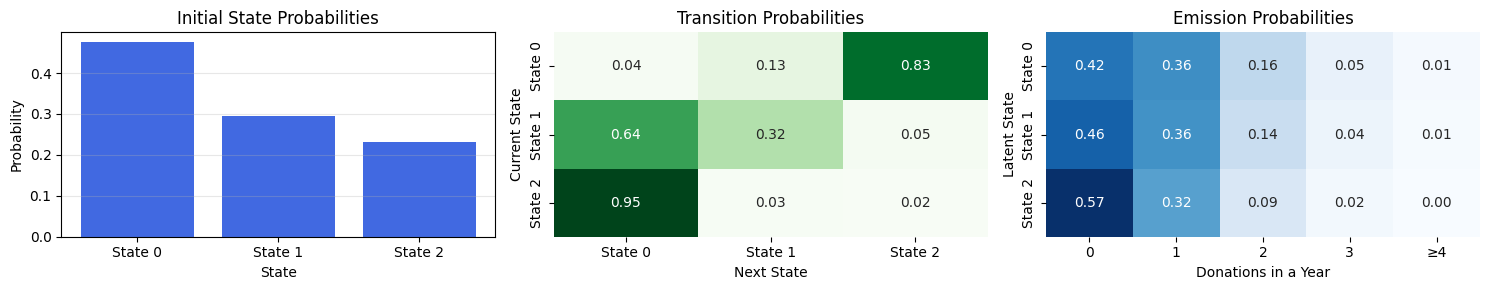

In [101]:
print("Probabilità iniziali (media popolazione):", init_probs)
print("Rate Poisson per stato:", rate)
print("Matrice di transizione (media sulle covariate):\n", transitions)


plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

#### Negative Binomial

In [ ]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import config_enumerate

@config_enumerate
def model(observations, donors_covariates):
    N, T = observations.shape
    K = 3
    C = donors_covariates.shape[2]

    # Parametri emissioni per stato: total_count e prob
    total_count = pyro.param("total_count", torch.ones(K), constraint=constraints.positive)
    logits = pyro.param("emiss_logits", torch.zeros(K))  # per la prob: prob = sigmoid(logits)

    # Parametri iniziali
    init_logits = pyro.param("init_logits", torch.zeros(K))
    # Parametri transizione
    trans_W = pyro.param("trans_W", torch.zeros(K, K, C))
    trans_b = pyro.param("trans_b", torch.zeros(K, K))

    with pyro.plate("donors", N):
        # Stato iniziale
        z_prev = pyro.sample("z_0", dist.Categorical(logits=init_logits))
        # Emissione iniziale: NB
        nb_total = total_count[z_prev]
        nb_prob = torch.sigmoid(logits[z_prev])
        pyro.sample("obs_0", dist.NegativeBinomial(total_count=nb_total, probs=nb_prob), obs=observations[:, 0])

        for t in range(1, T):
            trans_W_zprev = trans_W[z_prev]           # (N, K, C)
            trans_b_zprev = trans_b[z_prev]           # (N, K)
            covs = donors_covariates[:, t, :]         # (N, C)
            trans_logits = (trans_W_zprev * covs[:, None, :]).sum(-1) + trans_b_zprev  # (N, K)
            
            z_t = pyro.sample(f"z_{t}", dist.Categorical(logits=trans_logits))
            # Emissione Negative Binomial
            nb_total = total_count[z_t]
            nb_prob = torch.sigmoid(logits[z_t])
            pyro.sample(f"obs_{t}", dist.NegativeBinomial(total_count=nb_total, probs=nb_prob), obs=observations[:, t])
            
            z_prev = z_t

@config_enumerate
def guide(observations, donors_covariates):
    # Mean field: lasciamo che Pyro gestisca tutto
    pass

In [ ]:
pyro.clear_param_store()
optimizer = Adam({"lr": 0.1})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)
n_steps = 2_000
for step in range(n_steps):
    loss = svi.step(obs_torch, covariates_torch)
    if step % 200 == 0:
        print(f"[{step}] Loss = {loss:.2f}")


In [ ]:
# Recupera i valori ottimizzati
total_count = pyro.param("total_count").detach().cpu().numpy()   # shape (K,)
emiss_logits = pyro.param("emiss_logits").detach().cpu().numpy() # shape (K,)
probs = 1 / (1 + np.exp(-emiss_logits))  # sigmoid

print("Rate Negative Binomial per stato:")
for k in range(len(total_count)):
    print(f"  Stato {k}: total_count = {total_count[k]:.3f}, prob = {probs[k]:.3f}")

In [ ]:
means = total_count * (1 - probs) / probs
print("Media Negative Binomial per stato:")
for k in range(len(total_count)):
    print(f"  Stato {k}: mean = {means[k]:.3f}")

In [ ]:
import numpy as np

# 1. Estrai i parametri stimati
total_count = pyro.param("total_count").detach().cpu().numpy()    # [K]
emiss_logits = pyro.param("emiss_logits").detach().cpu().numpy()  # [K]
probs = 1 / (1 + np.exp(-emiss_logits))                          # [K]

# for dependency with init_W and init_b
# init_W = pyro.param("init_W").detach().cpu().numpy()  # [K, C]
# init_b = pyro.param("init_b").detach().cpu().numpy()  # [K]
# covs_0 = covariates_torch[:, 0, :].cpu().numpy()      # [N, C]
# logits = covs_0 @ init_W.T + init_b                   # [N, K]
# probs_init = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)  # [N, K]
# init_probs = probs_init.mean(axis=0)                  # [K]

# Only inital logits
init_logits = pyro.param("init_logits").detach().cpu().numpy()  # [K]
init_probs = np.exp(init_logits) / np.exp(init_logits).sum()    # [K]

K, C = pyro.param("trans_W").shape[-2:]
trans_W = pyro.param("trans_W").detach().cpu().numpy()  # [K, K, C]
trans_b = pyro.param("trans_b").detach().cpu().numpy()  # [K, K]
covs = covariates_torch.cpu().numpy()                   # [N, T, C]

# Media sulle covariate del primo anno
covs_mean = covs[:, 0, :].mean(axis=0)  # [C]

# Matrice di transizione media per ogni stato
transitions = np.zeros((K, K))
for prev in range(K):
    logits = trans_b[prev] + trans_W[prev] @ covs_mean  # [K]
    probs_tr = np.exp(logits) / np.exp(logits).sum()
    transitions[prev, :] = probs_tr

# Costruisci la matrice di emissione Negative Binomial (truncated)
def build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4):
    from scipy.stats import nbinom
    S = len(total_count)
    K = max_k + 1
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = nbinom.pmf(k, total_count[s], probs[s])
        emissions[s, max_k] = 1 - nbinom.cdf(max_k-1, total_count[s], probs[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4)

# Stampa i risultati numerici
print("Probabilità iniziali (media popolazione):", init_probs)
print("Negative Binomial total_count per stato:", total_count)
print("Negative Binomial probs per stato:", probs)
print("Matrice di transizione (media sulle covariate):\n", transitions)

plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

In [ ]:
import pandas as pd
rows = []
for i in range(K):
    for j in range(K):
        for c, name in enumerate(['birth_year_norm', 'gender_code']):
            rows.append({'from': i, 'to': j, 'covariate': name, 'weight': trans_W[i,j,c]})
df = pd.DataFrame(rows)
print(df.pivot_table(index=['from', 'to'], columns='covariate', values='weight'))

### Dynamic Covariates

#### Negative Binomial

In [ ]:
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO

pyro.clear_param_store()
optimizer = Adam({"lr": 0.1, "weight_decay": 0.1})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, guide, optimizer, loss=elbo)

num_steps = 2_000
for step in range(num_steps):
    loss = svi.step(obs_torch, full_cov_torch)
    # Aggiungi la penalità soft alle emissioni, dopo ogni step
    # penalty = emission_penalty(weight=10.0)
    penalty = total_penalty()
    total_loss = loss + penalty.item()
    if step % (num_steps // 10) == 0:
        print(f"Step {step} : loss = {loss:.2f} (penalty: {penalty.item():.2f})  tot: {total_loss:.2f}")

Step 0 : loss = 254705.47 (penalty: 6.19)  tot: 254711.66


KeyboardInterrupt: 

In [202]:
# ────────────────────────────────────────────────────────────────
#  HMM a stati discreti con emissioni Negative Binomial,
#  rivisto per far sì che lo STATE 0 sia visitato più spesso
# ────────────────────────────────────────────────────────────────
import torch, pyro
# from pyro import constraints
from pyro.infer import config_enumerate, SVI, TraceEnum_ELBO
from pyro.optim import Adam
import pyro.distributions as dist

K = 3                                # numero stati nascosti
# ---------- TARGET (usate per “penalties” o come vere prior) ----
#   Stato 0 ora ha mean ≈ 0.5 invece di 0.01
target_total_count = torch.tensor([2.0, 1.5, 1.5])
target_probs       = torch.tensor([0.80, 0.50, 0.30])

target_init_probs  = torch.tensor([0.60, 0.20, 0.20])
target_trans_probs = torch.tensor([[0.70, 0.15, 0.15],
                                   [0.25, 0.50, 0.25],
                                   [0.25, 0.25, 0.50]])

# ---------- PARAM INIT ---------------------------------------------------------
init_total_count = target_total_count.clone()
init_logits      = torch.logit(target_probs.clone())   # emiss logits

# ───────────────────────────────────────────────── MODEL ────────────────────────
@config_enumerate
def model(observations, donors_covariates):
    N, T = observations.shape
    C    = donors_covariates.shape[2]

    # PARAMETRI LEARNABLE (usiamo pyro.param)
    total_count = pyro.param("total_count",
                             init_total_count.clone(),
                             constraint=constraints.positive)
    emiss_logits = pyro.param("emiss_logits",
                              init_logits.clone())            # shape (K,)

    init_logits_param = pyro.param("init_logits", torch.zeros(K))
    trans_W  = pyro.param("trans_W", torch.zeros(K, K, C))
    trans_b  = pyro.param("trans_b", torch.zeros(K, K))

    # ------------------ modello generativo -------------------------------------
    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0",
                             dist.Categorical(logits=init_logits_param),
                             infer={"enumerate": "parallel"})

        nb_total = total_count[z_prev]
        nb_prob  = torch.sigmoid(emiss_logits[z_prev])
        pyro.sample("obs_0",
                    dist.NegativeBinomial(total_count=nb_total, probs=nb_prob),
                    obs=observations[:, 0])

        for t in range(1, T):
            cov_t = donors_covariates[:, t, :]                # (N, C)
            trans_logits = (trans_W[z_prev] * cov_t[:, None, :]).sum(-1) + trans_b[z_prev]
            z_t = pyro.sample(f"z_{t}",
                              dist.Categorical(logits=trans_logits),
                              infer={"enumerate": "parallel"})

            nb_total = total_count[z_t]
            nb_prob  = torch.sigmoid(emiss_logits[z_t])
            pyro.sample(f"obs_{t}",
                        dist.NegativeBinomial(total_count=nb_total, probs=nb_prob),
                        obs=observations[:, t])
            z_prev = z_t

    # --------------- soft-constraint via penalty ------------------------------
    pyro.factor("all_penalties", -total_penalty())

# ────────────────────────────────────────── GUIDE ──────────────────────────────
def guide(observations, donors_covariates):
    N, T = observations.shape
    C    = donors_covariates.shape[2]

    trans_W_q = pyro.param("trans_W_q", torch.zeros(K, K, C))
    trans_b_q = pyro.param("trans_b_q", torch.zeros(K, K))
    init_logits_q = pyro.param("init_logits_q", torch.zeros(K))

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0", dist.Categorical(logits=init_logits_q))
        for t in range(1, T):
            cov_t      = donors_covariates[:, t, :]
            logits_q   = (trans_W_q[z_prev] * cov_t[:, None, :]).sum(-1) + trans_b_q[z_prev]
            z_prev     = pyro.sample(f"z_{t}", dist.Categorical(logits=logits_q))

# ─────────────────────────────── PENALTIES (riviste) ───────────────────────────
def emission_penalty():
    w = torch.tensor([200.0, 10.0, 40.0])          # ↑↑ stato 0, un po’ stato 2
    tot   = pyro.param("total_count")
    prob  = torch.sigmoid(pyro.param("emiss_logits"))
    return ((w*(tot  - target_total_count)**2).sum() +
            (w*(prob - target_probs)      **2).sum())

def initial_state_penalty():
    init_p = torch.softmax(pyro.param("init_logits"), -1)
    return 200.0*((init_p - target_init_probs)**2).sum()

def transition_penalty():
    trans_p = torch.softmax(pyro.param("trans_b"), -1)
    W = torch.tensor([[200.,  40.,  40.],          # riga 0 → voglio diag alta
                      [ 20.,  10.,  20.],
                      [ 20.,  20.,  10.]])
    return ((W*(trans_p - target_trans_probs)**2)).sum()

def total_penalty():
    return (emission_penalty() +
            initial_state_penalty() +
            transition_penalty())

# ───────────────────────────────────── TRAINING LOOP ───────────────────────────
pyro.clear_param_store()
optimizer = Adam({"lr": 0.05, "weight_decay": 0.0})      # meno weight-decay
elbo      = TraceEnum_ELBO(max_plate_nesting=1)
svi       = SVI(model, guide, optimizer, loss=elbo)

num_steps = 10_000
for step in range(num_steps):
    loss    = svi.step(obs_torch, full_cov_torch)
    penalty = total_penalty().item()
    if step % (num_steps // 10) == 0:
        print(f"step {step:3d} | ELBO {loss:,.0f} | penalty {penalty:6.2f} | total {loss+penalty:,.0f}")

In [ ]:
import numpy as np

# Recupera i valori ottimizzati
total_count = pyro.param("total_count").detach().cpu().numpy()   # shape (K,)
emiss_logits = pyro.param("emiss_logits").detach().cpu().numpy() # shape (K,)
probs = 1 / (1 + np.exp(-emiss_logits))  # sigmoid

print("Rate Negative Binomial per stato:")
for k in range(len(total_count)):
    print(f"  Stato {k}: total_count = {total_count[k]:.3f}, prob = {probs[k]:.3f}")
init_logits = pyro.param("init_logits").detach().cpu().numpy()  # [K]
init_probs = np.exp(init_logits) / np.exp(init_logits).sum()    # [K]

K, C = pyro.param("trans_W").shape[-2:]
trans_W = pyro.param("trans_W").detach().cpu().numpy()  # [K, K, C]
trans_b = pyro.param("trans_b").detach().cpu().numpy()  # [K, K]
covs = full_cov_torch.cpu().numpy()                   # [N, T, C]

# Media sulle covariate del primo anno
covs_mean = covs[:, 0, :].mean(axis=0)  # [C]

# Matrice di transizione media per ogni stato
transitions = np.zeros((K, K))
for prev in range(K):
    logits = trans_b[prev] + trans_W[prev] @ covs_mean  # [K]
    probs_tr = np.exp(logits) / np.exp(logits).sum()
    transitions[prev, :] = probs_tr

# Costruisci la matrice di emissione Negative Binomial (truncated)
def build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4):
    from scipy.stats import nbinom
    S = len(total_count)
    K = max_k + 1
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = nbinom.pmf(k, total_count[s], probs[s])
        emissions[s, max_k] = 1 - nbinom.cdf(max_k-1, total_count[s], probs[s])
    return emissions

emissions_matrix = build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4)

# Stampa i risultati numerici
print("Probabilità iniziali (media popolazione):", init_probs)
print("Negative Binomial total_count per stato:", total_count)
print("Negative Binomial probs per stato:", probs)
print("Matrice di transizione (media sulle covariate):\n", transitions)
# with torch.no_grad():
#     probs = [torch.softmax(pyro.param("init_logits"), -1)]
#     P = torch.softmax(pyro.param("trans_b"), -1)
#     print("Init-probs:", probs)
#     print("Transizione:\n", P.cpu().numpy())

plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

In [ ]:
import numpy as np

# Esempio per 'ages_norm'
ages_range = np.linspace(-2, 2, 21)  # da molto giovani a molto anziani (normalizzato)
covs_mean = full_covariates.mean(axis=(0,1))  # [C]
matrici = []

for age in ages_range:
    x = covs_mean.copy()
    x[2] = age  # supponiamo ages_norm sia la terza covariata
    trans_matrices = []
    for prev in range(K):
        logits = trans_b[prev] + trans_W[prev] @ x
        probs_tr = np.exp(logits) / np.exp(logits).sum()
        trans_matrices.append(probs_tr)
    matrici.append(np.array(trans_matrices))  # shape (K, K)

# Ad esempio: transizione dallo stato 0 a 2 in funzione dell'età
plt.plot(ages_range, [mat[0,1] for mat in matrici])
plt.xlabel("ages_norm")
plt.ylabel("P(0→2)")
plt.title("Probabilità di transizione 0→1 al variare dell'età normalizzata")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

K = trans_b.shape[0]  # Numero di stati
C = trans_W.shape[2]  # Numero di covariate

ages_range = np.linspace(-2, 2, 21)
covs_mean = full_covariates.mean(axis=(0,1))  # [C]
matrici = []

for age in ages_range:
    x = covs_mean.copy()
    # supponiamo ages_norm sia la covariata indice idx_age
    idx_age = 2  # cambialo se ages_norm non è la terza!
    x[idx_age] = age
    trans_matrices = []
    for prev in range(K):
        logits = trans_b[prev] + trans_W[prev] @ x
        probs_tr = np.exp(logits) / np.exp(logits).sum()
        trans_matrices.append(probs_tr)
    matrici.append(np.array(trans_matrices))  # shape (K, K)

matrici = np.array(matrici)  # shape (len(ages_range), K, K)

# Plot a griglia: ogni subplot è la transizione da i a j
fig, axes = plt.subplots(K, K, figsize=(K*3, K*3), sharex=True, sharey=True)
for i in range(K):
    for j in range(K):
        axes[i, j].plot(ages_range, matrici[:, i, j])
        axes[i, j].set_title(f'P({i}→{j})')
        if i == K-1:
            axes[i, j].set_xlabel('ages_norm')
        if j == 0:
            axes[i, j].set_ylabel('Prob')
plt.suptitle('Probabilità di transizione al variare di ages_norm')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_transition_grid(var_name, covariate_names, trans_b, trans_W, full_covariates, grid_vals=None):
    """
    Draws K×K small multiples of transition probabilities versus a covariate.

    • If the covariate has ≤2 distinct values -> bar plot (one bar per value).  
    • Otherwise -> line plot on grid_vals (default linspace(-2, 2, 21)).
    """
    K   = trans_b.shape[0]
    idx = covariate_names.index(var_name)

    # ------------------------------------------------------------------
    # Choose values at which to evaluate the covariate
    # ------------------------------------------------------------------
    if grid_vals is None:
        unique_vals = np.unique(full_covariates[..., idx])

        # Treat as categorical when two or fewer distinct values exist
        if len(unique_vals) <= 2:
            grid_vals = unique_vals.astype(float)
            plot_mode = "bar"
        else:
            grid_vals = np.linspace(-2, 2, 21)
            plot_mode = "line"
    else:
        plot_mode = "line"

    # ------------------------------------------------------------------
    # Build transition matrices for each value in grid_vals
    # ------------------------------------------------------------------
    covs_mean = full_covariates.mean(axis=(0, 1))      # Shape [C]
    matrices  = []                                     # Will become (G, K, K)

    for v in grid_vals:
        x = covs_mean.copy()
        x[idx] = v
        P = []
        for prev in range(K):
            logits = trans_b[prev] + trans_W[prev] @ x
            probs  = np.exp(logits) / np.exp(logits).sum()
            P.append(probs)
        matrices.append(np.vstack(P))

    matrices = np.stack(matrices)  # Shape (G, K, K)

    # ------------------------------------------------------------------
    # Plotting
    # ------------------------------------------------------------------
    fig, axes = plt.subplots(K, K, figsize=(K*2.4, K*2.4),
                             sharex=True, sharey=True)

    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            if plot_mode == "line":
                ax.plot(grid_vals, matrices[:, i, j])
            else:  # bar plot
                bar_width = 0.6
                ax.bar(grid_vals, matrices[:, i, j],
                       width=bar_width, color=['#1f77b4', '#ff7f0e'])
                ax.set_xticks(grid_vals)

            ax.set_title(f"P({i}→{j})", fontsize=8)
            if i == K - 1:
                ax.set_xlabel(var_name)
            if j == 0:
                ax.set_ylabel("Prob")

    plt.suptitle(f"Transition probabilities vs {var_name}", y=1.02)
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------
# Call the function for every covariate in the CORRECT order
# ------------------------------------------------------------------
cov_names = [
    "const",
    "birth_year_norm",  # 0 continuous
             "gender_code",      # 1 binary
             "ages_norm",        # 2 continuous
             "covid_years"]      # 3 binary

for name in cov_names:
    plot_transition_grid(name, cov_names,
                         trans_b, trans_W, full_covariates)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_weights_grid(
        trans_W,
        covariate_names,
        *,
        const_first=False,
        skip_const=False
):
    """
    Plot a K×K grid of barplots for the weight tensor `trans_W`
    using neutral grey colours and no seaborn.

    Parameters
    ----------
    trans_W : ndarray, shape (K, K, C)
    covariate_names : list[str]  length = C
    const_first : bool, default False
        If True, the column named 'const' is plotted first.
    skip_const : bool, default False
        If True, the column named 'const' is removed from the plot.
    """
    # --------------------------------------------------------------
    # basic checks
    # --------------------------------------------------------------
    if trans_W.shape[2] != len(covariate_names):
        raise ValueError("`trans_W` and `covariate_names` length mismatch")

    idx = list(range(len(covariate_names)))           # [0, 1, …, C-1]

    # --------------------------------------------------------------
    # handle constant column
    # --------------------------------------------------------------
    if "const" in covariate_names:
        const_idx = covariate_names.index("const")

        if skip_const:
            idx.remove(const_idx)                     # drop it
        elif const_first:
            idx = [const_idx] + [i for i in idx if i != const_idx]

    # --------------------------------------------------------------
    # reorder data for plotting only
    # --------------------------------------------------------------
    names_plot = [covariate_names[i] for i in idx]
    W_plot     = trans_W[..., idx]                    # shape (K, K, C_plot)

    K, _, C_plot = W_plot.shape

    # --------------------------------------------------------------
    # pick neutral colours (light → dark grey)
    # --------------------------------------------------------------
    greys = plt.cm.Greys(np.linspace(0.3, 0.7, C_plot))

    # --------------------------------------------------------------
    # plotting
    # --------------------------------------------------------------
    fig, axes = plt.subplots(K, K, figsize=(K * 2.4, K * 2.4), sharex=True)

    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            ax.bar(
                x=np.arange(C_plot),
                height=W_plot[i, j],
                color=greys,
                edgecolor='black',
                linewidth=0.3
            )
            ax.set_title(f"W({i}→{j})", fontsize=8)
            ax.set_xticks(np.arange(C_plot))
            if i == K - 1:
                ax.set_xticklabels(names_plot, rotation=90)
            else:
                ax.set_xticklabels([])

    plt.suptitle("Covariate weights for each transition", y=1.03)
    plt.tight_layout()
    plt.show()


# --------------------------------------------------------------
# example call
# --------------------------------------------------------------
cov_names = ["birth_year_norm",    # 0
             "gender_code",        # 1
             "ages_norm",          # 2
             "covid_years",        # 3
             "const"]              # 4

plot_weights_grid(trans_W, cov_names, const_first=True, skip_const=False)

In [ ]:
import pandas as pd
rows = []
for i in range(K):
    for j in range(K):
        for c, name in enumerate(['birth_year_norm', 'gender_code', 'ages_norm', 'covid_years']):
            rows.append({'from': i, 'to': j, 'covariate': name, 'weight': trans_W[i,j,c]})
df = pd.DataFrame(rows)
print(df.pivot_table(index=['from', 'to'], columns='covariate', values='weight'))

#### Model with soft penalties and uninformative prior

In [ ]:
# ───────────────────────── IMPORT ──────────────────────────
import torch, pyro, pyro.distributions as dist
import torch.nn.functional as F
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam
# from pyro import constraints
import numpy as np
from scipy.stats import nbinom

# ───────────────────────── TARGET (solo per iniz.) ─────────
K = 3
target_total_count = torch.tensor([2.0, 1.5, 1.5])
target_probs       = torch.tensor([0.80, 0.50, 0.30])
target_init_probs  = torch.tensor([0.60, 0.20, 0.20])

# helper: inizializzazione di W quando avremo C
def make_init_trans_W0(C):
    return 0.01 * torch.randn(K, K, C)

emiss_init_logits   = torch.logit(target_probs)      # NB
state_init_logits0  = torch.log(target_init_probs)   # stati iniziali

# ───────────────────────── MODEL ───────────────────────────
@config_enumerate
def model(obs, cov):
    N, T = obs.shape
    C    = cov.size(-1)

    # emissioni NB
    total_count  = pyro.param("total_count",
                              target_total_count.clone(),
                              constraint=constraints.positive)
    emiss_logits = pyro.param("emiss_logits",
                              emiss_init_logits.clone())

    # iniziali + transizioni
    state_init_logits = pyro.param("state_init_logits",
                                   state_init_logits0.clone())
    trans_W = pyro.param("trans_W", make_init_trans_W0(C))   # (K,K,C)
    trans_b = pyro.param("trans_b", torch.zeros(K, K))       # log-uniform

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0",
                             dist.Categorical(logits=state_init_logits),
                             infer={"enumerate": "parallel"})

        # primo anno
        nb_tot = total_count[z_prev]
        nb_p   = torch.sigmoid(emiss_logits[z_prev])
        pyro.sample("obs_0",
                    dist.NegativeBinomial(total_count=nb_tot, probs=nb_p),
                    obs=obs[:, 0])

        # anni successivi
        for t in range(1, T):
            logits = (trans_W[z_prev] * cov[:, t, None, :]).sum(-1) + trans_b[z_prev]
            z_t = pyro.sample(f"z_{t}",
                              dist.Categorical(logits=logits),
                              infer={"enumerate": "parallel"})

            nb_tot = total_count[z_t]
            nb_p   = torch.sigmoid(emiss_logits[z_t])
            pyro.sample(f"obs_{t}",
                        dist.NegativeBinomial(total_count=nb_tot, probs=nb_p),
                        obs=obs[:, t])
            z_prev = z_t

# ───────────────────────── GUIDE ───────────────────────────
@config_enumerate
def guide(obs, cov):
    N, T = obs.shape
    C    = cov.size(-1)

    trans_W_q     = pyro.param("trans_W_q", torch.zeros(K, K, C))
    trans_b_q     = pyro.param("trans_b_q", torch.zeros(K, K))
    init_logits_q = pyro.param("init_logits_q", torch.zeros(K))

    with pyro.plate("donors", N):
        z_prev = pyro.sample("z_0", dist.Categorical(logits=init_logits_q))
        for t in range(1, T):
            logits_q = (trans_W_q[z_prev] * cov[:, t, None, :]).sum(-1) + trans_b_q[z_prev]
            z_prev   = pyro.sample(f"z_{t}", dist.Categorical(logits=logits_q))

# ───────────────────────── TRAINING LOOP ──────────────────
# >>> inserisci qui i tuoi tensori: obs_torch (N,T) e full_cov_torch (N,T,C)
# obs_torch        = ...
# full_cov_torch   = ...

pyro.clear_param_store()
svi = SVI(model, guide, Adam({"lr": 0.03}),
          loss=TraceEnum_ELBO(max_plate_nesting=1))

for step in range(5000):
    loss = svi.step(obs_torch, full_cov_torch)
    if step % 500 == 0:
        print(f"{step:5d}  ELBO = {loss:,.0f}")

# ───────────────────────── DIAGNOSTICA ─────────────────────
tot_cnt   = pyro.param("total_count").detach().cpu().numpy()        # (K,)
e_logits  = pyro.param("emiss_logits").detach().cpu().numpy()
p_nb      = 1 / (1 + np.exp(-e_logits))

init_log  = pyro.param("state_init_logits").detach().cpu().numpy()
init_prob = np.exp(init_log) / np.exp(init_log).sum()

W = pyro.param("trans_W").detach().cpu().numpy()    # (K,K,C)
b = pyro.param("trans_b").detach().cpu().numpy()    # (K,K)
cov_mean = full_cov_torch[:, 0, :].mean(0).cpu().numpy()

P = np.zeros((K, K))
for k in range(K):
    logits = b[k] + W[k] @ cov_mean
    P[k]   = np.exp(logits) / np.exp(logits).sum()

print("\nRate Negative Binomial per stato:")
for k in range(K):
    print(f"  stato {k}: total_count = {tot_cnt[k]:.3f}, prob = {p_nb[k]:.3f}")
print("\nProbabilità iniziali:", init_prob)
print("Matrice di transizione (media covariate):\n", P)

# ───────────────────────── EMISSION MATRIX (opz.) ──────────
def build_emission_matrix_truncated_nbinom(total_count, probs, max_k=4):
    S, Kk = len(total_count), max_k + 1
    M = np.zeros((S, Kk))
    for s in range(S):
        for k in range(max_k):
            M[s, k] = nbinom.pmf(k, total_count[s], probs[s])
        M[s, max_k] = 1 - nbinom.cdf(max_k - 1, total_count[s], probs[s])
    return M

emission_mat = build_emission_matrix_truncated_nbinom(tot_cnt, p_nb)

c:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyro\infer\traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


    0  ELBO = 256,005
  500  ELBO = 154,991
 1000  ELBO = 154,162
 1500  ELBO = 153,857
 2000  ELBO = 153,774
 2500  ELBO = 153,766
 3000  ELBO = 153,580
 3500  ELBO = 153,240
 4000  ELBO = 152,782
 4500  ELBO = 152,743

Rate Negative Binomial per stato:
  stato 0: total_count = 1.082, prob = 0.445
  stato 1: total_count = 14.228, prob = 0.075
  stato 2: total_count = 0.306, prob = 0.502

Probabilità iniziali: [4.8815942e-05 1.7396404e-05 9.9993384e-01]
Matrice di transizione (media covariate):
 [[9.98841107e-01 9.05521854e-04 2.53337639e-04]
 [1.19403144e-03 9.98430192e-01 3.75789881e-04]
 [4.10577003e-03 1.76278791e-05 9.95876610e-01]]


Rate Negative Binomial per stato:
  Stato 0: total_count = 1.082, prob = 0.445
  Stato 1: total_count = 14.228, prob = 0.075
  Stato 2: total_count = 0.306, prob = 0.502

Probabilità iniziali (media popolazione): [4.8815942e-05 1.7396404e-05 9.9993384e-01]
Matrice di transizione (media covariate):
 [[9.98841107e-01 9.05513240e-04 2.53337435e-04]
 [1.19403435e-03 9.98430192e-01 3.75791133e-04]
 [4.10572812e-03 1.76276717e-05 9.95876670e-01]]


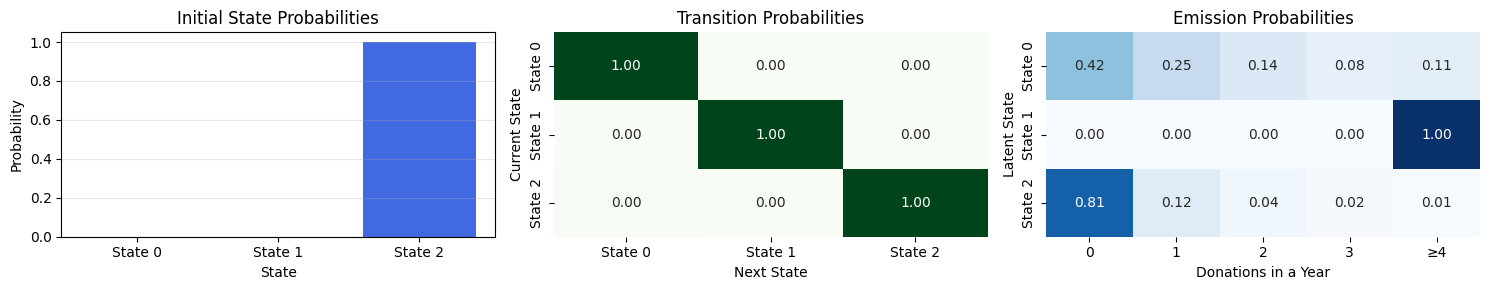

In [239]:
import numpy as np

store = pyro.get_param_store()          # comodo per fare debug

# ---------------- emissioni NB ---------------------------------
total_count  = pyro.param("total_count").detach().cpu().numpy()      # (K,)
emiss_logits = pyro.param("emiss_logits").detach().cpu().numpy()     # (K,)
probs        = 1 / (1 + np.exp(-emiss_logits))                       # sigmoid

print("Rate Negative Binomial per stato:")
for k in range(len(total_count)):
    print(f"  Stato {k}: total_count = {total_count[k]:.3f}, prob = {probs[k]:.3f}")

# ---------------- probabilità iniziali -------------------------
state_init_logits = pyro.param("state_init_logits").detach().cpu().numpy()  # (K,)
init_probs = np.exp(state_init_logits) / np.exp(state_init_logits).sum()

# ---------------- transizioni medie ----------------------------
K, C = pyro.param("trans_W").shape[-2:]
trans_W = pyro.param("trans_W").detach().cpu().numpy()   # (K, K, C)
trans_b = pyro.param("trans_b").detach().cpu().numpy()   # (K, K)

covs   = full_cov_torch.cpu().numpy()                   # (N, T, C)
covs_mean = covs[:, 0, :].mean(axis=0)                  # (C,)

transitions = np.zeros((K, K))
for prev in range(K):
    logits   = trans_b[prev] + trans_W[prev] @ covs_mean
    probs_tr = np.exp(logits) / np.exp(logits).sum()
    transitions[prev] = probs_tr

# ---------------- matrice di emissione (troncata) --------------
def build_emission_matrix_truncated_nbinom(tot_cnt, pr, max_k=4):
    from scipy.stats import nbinom
    S = len(tot_cnt)
    G = max_k + 1
    out = np.zeros((S, G))
    for s in range(S):
        for k in range(max_k):
            out[s, k] = nbinom.pmf(k, tot_cnt[s], pr[s])
        out[s, max_k] = 1 - nbinom.cdf(max_k - 1, 
                                       tot_cnt[s], pr[s])
    return out

emissions_matrix = build_emission_matrix_truncated_nbinom(total_count, probs)

# ---------------------- stampa e plot --------------------------
print("\nProbabilità iniziali (media popolazione):", init_probs)
print("Matrice di transizione (media covariate):\n", transitions)

plot_hmm_params(
    transitions=transitions,
    initial_probs=init_probs,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

#### Viterbi algorithm

In [294]:
def infer_one_path_for_everybody():
    """
    Restituisce tensor (N, T) con il percorso di massima verosimiglianza
    per ogni donatore, usando i parametri correnti di Pyro.
    """
    with torch.no_grad():
        # prendi parametri ‘freezed’
        tot_cnt = pyro.param("total_count").detach()
        e_logits = pyro.param("emiss_logits").detach()
        init_logits = pyro.param("init_logits").detach()
        W   = pyro.param("trans_W").detach()
        b   = pyro.param("trans_b").detach()

        N, T = obs_torch.shape
        C    = full_cov_torch.size(2)
        paths = torch.zeros(N, T, dtype=torch.long)

        # pre-compute emission log-prob per ciascun (k,t,n)
        emis_log = torch.empty(N, T, K)
        for k in range(K):
            nb = dist.NegativeBinomial(total_count=tot_cnt[k],
                                       probs=torch.sigmoid(e_logits[k]))
            emis_log[:, :, k] = nb.log_prob(obs_torch)

        # loop sui donatori
        for n in range(N):
            # delta / psi per Viterbi
            delta = init_logits + emis_log[n, 0]          # (K,)
            psi   = torch.zeros(T, K, dtype=torch.long)

            for t in range(1, T):
                cov_t = full_cov_torch[n, t]              # (C,)
                # log-prob di transizione: shape (K_prev, K_next)
                logits = (W * cov_t).sum(-1) + b          # broadcast KxKxC → KxK
                log_trans = F.log_softmax(logits, dim=1)  # righe = prev
                # sommo a delta_prev (broadcast)
                score = delta[:, None] + log_trans        # (K_prev, K_next)
                delta, psi[t] = torch.max(score, dim=0)   # max over prev
                delta += emis_log[n, t]                   # aggiungo emissione

            # back-tracking
            last = torch.argmax(delta).item()
            paths[n, -1] = last
            for t in range(T-1, 0, -1):
                last = psi[t, last].item()
                paths[n, t-1] = last
        return paths
    
paths = infer_one_path_for_everybody()
switch = (paths[:,1:] != paths[:,:-1]).any(1).float().mean()
print("Sequenze con ≥1 switch:", switch.item()*100, "%")

Sequenze con ≥1 switch: 29.449978470802307 %


### Beta Binomial

#### 3 states